<b><font color="SteelBlue" size="+3">Anticipez les besoins en consommation de bâtiments</font></b>

# Introduction

## Contexte

Le projet se situe dans le cadre des efforts de la ville de Seattle pour atteindre son objectif de neutralité carbone d'ici 2050, un enjeu majeur dans la lutte contre le changement climatique. L'accent est mis sur l'analyse de la consommation énergétique et des émissions de dioxyde de carbone (CO2) des bâtiments non résidentiels, une composante significative de l'empreinte carbone de la ville. Pour cela, la ville dispose de données collectées en 2016, reflétant les consommations et émissions des bâtiments à cette période. Ces données, bien que précieuses, sont coûteuses et laborieuses à obtenir, d'où l'intérêt de développer un modèle prédictif capable d'estimer ces indicateurs pour les bâtiments non encore analysés, basé sur des caractéristiques structurelles telles que la taille, l'usage, la date de construction, ou encore la situation géographique des bâtiments.

## Objectifs

Tout d'abvord, réaliser une analyse exploratoire des données disponibles afin d'identifier les tendances, les anomalies et les relations potentielles entre les différentes variables. Et ensuite tester et comparer différents modèles de machine learning pour prédire avec précision la consommation totale d'énergie et les émissions de CO2 des bâtiments non résidentiels, sans données de consommation annuelle future, pour éviter toute fuite de données. Un intérêt particulier est porté à l'évaluation de l'utilité de l'"ENERGY STAR Score", un indicateur potentiellement pertinent mais complexe à calculer avec les méthodes actuelles.


## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.cluster import KMeans
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from IPython.display import Image

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_exploratoire_022024.ipynb',
 'Deveau_Estelle_2_notebook_prediction_EnergyUse_022024.ipynb',
 'Deveau_Estelle_3_notebook_prediction_GHGEmissions_022024.ipynb',
 'Map_of_Seattle,_divided_by_districts.png',
 'OC_projet4.pptx',
 'svg',
 '~$OC_projet4.pptx']

In [3]:
os.listdir("data/sources/")

['2016_Building_Energy_Benchmarking.csv']

In [4]:
path     = "./data/sources/"
filename = "2016_Building_Energy_Benchmarking.csv"

In [5]:
data = pd.read_csv(path + filename)

In [6]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Exploration des données

## Quick tour

In [7]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [8]:
data.shape

(3376, 46)

In [9]:
data.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
Name: count, dtype: int64

In [10]:
data.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3376.000000      3.376000e+03         3376.000000   
mean         4.709123      9.483354e+04         8001.526066   
std          5.494465      2.188376e+05        32326.723928   
min          0.000000      1.128500e+04            0.000000   
25%          2.000000      2.848700e+04            0.000000   
50%          4.000000      4.417500e+04            0.000000   
75%          5.000000      9.099200e+04            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.376000e+03               3.356000e+03   
mean             8.683201e+04               7.917764e+04   
std              2.079398e+05               2.017034e+05   
min              3.636000e+03               5.656000e+03   
25%              2.775600e+04               2.509475e+04   
50%              4.321600e+04               3.989400e+04   
75%              8.427625e+04               7.620025e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1679.000000                      596.000000   
mean                      28444.075817                    11738.675166   
std                       54392.917928                    29331.199286   
min                           0.000000                        0.000000   
25%                        5000.000000                     2239.000000   
50%                       10664.000000                     5043.000000   
75%                       26640.000000                    10138.750000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count      2533.000000       3369.000000         3370.000000   
mean         67.918674         54.732116           57.033798   
std          26.873271         56.273124           57.163330   
min           1.000000          0.000000            0.000000   
25%          53.000000         27.900000           29.400000   
50%          75.000000         38.599998           40.900002   
75%          90.000000         60.400002           64.275002   
max         100.000000        834.400024          834.400024   

       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
count         3367.000000           3367.000000         3.371000e+03   
mean           134.232848            137.783932         5.403667e+06   
std            139.287554            139.109807         2.161063e+07   
min              0.000000             -2.100000         0.000000e+00   
25%             74.699997             78.400002         9.251286e+05

In [11]:
data.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [12]:
# Valeurs manquantes
missing_values_count = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 12.85 %


In [13]:
percent_missing_values =  round((missing_values_count / len(data)) * 100, 2)
missing_data = pd.concat([missing_values_count, percent_missing_values], axis=1, keys=['Nombre de valeurs manquantes', 'Pourcentage de valeurs manquantes'])
display(missing_data)

Nombre de valeurs manquantes  \
OSEBuildingID                                               0   
DataYear                                                    0   
BuildingType                                                0   
PrimaryPropertyType                                         0   
PropertyName                                                0   
Address                                                     0   
City                                                        0   
State                                                       0   
ZipCode                                                    16   
TaxParcelIdentificationNumber                               0   
CouncilDistrictCode                                         0   
Neighborhood                                                0   
Latitude                                                    0   
Longitude                                                   0   
YearBuilt                                                   0   
NumberofBuildings                                           8   
NumberofFloors                                              0   
PropertyGFATotal                                            0   
PropertyGFAParking                                          0   
PropertyGFABuilding(s)                                      0   
ListOfAllPropertyUseTypes                                   9   
LargestPropertyUseType                                     20   
LargestPropertyUseTypeGFA                                  20   
SecondLargestPropertyUseType                             1697   
SecondLargestPropertyUseTypeGFA                          1697   
ThirdLargestPropertyUseType                              2780   
ThirdLargestPropertyUseTypeGFA                           2780   
YearsENERGYSTARCertified                                 3257   
ENERGYSTARScore                                           843   
SiteEUI(kBtu/sf)                                            7   
SiteEUIWN(kBtu/sf)                                          6   
SourceEUI(kBtu/sf)                                          9   
SourceEUIWN(kBtu/sf)                                        9   
SiteEnergyUse(kBtu)                                         5   
SiteEnergyUseWN(kBtu)                                       6   
SteamUse(kBtu)                                              9   
Electricity(kWh)                                            9   
Electricity(kBtu)                                           9   
NaturalGas(therms)                                          9   
NaturalGas(kBtu)                                            9   
DefaultData                                                 0   
Comments                                                 3376   
ComplianceStatus                                            0   
Outlier                                                  3344   
TotalGHGEmissions                                           9   
GHGEmissionsIntensity                                       9   

                                 Pourcentage de valeurs manquantes  
OSEBuildingID                                                 0.00  
DataYear                                                      0.00  
BuildingType                                                  0.00  
PrimaryPropertyType                                           0.00  
PropertyName                                                  0.00  
Address                                                       0.00  
City                                                          0.00  
State                                                         0.00  
ZipCode                                                       0.47  
TaxParcelIdentificationNumber                                 0.00  
CouncilDistrictCode                                           0.00  
Neighborhood                                                  0.00  
Latitude                                                      0.00  
Longitude  

<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

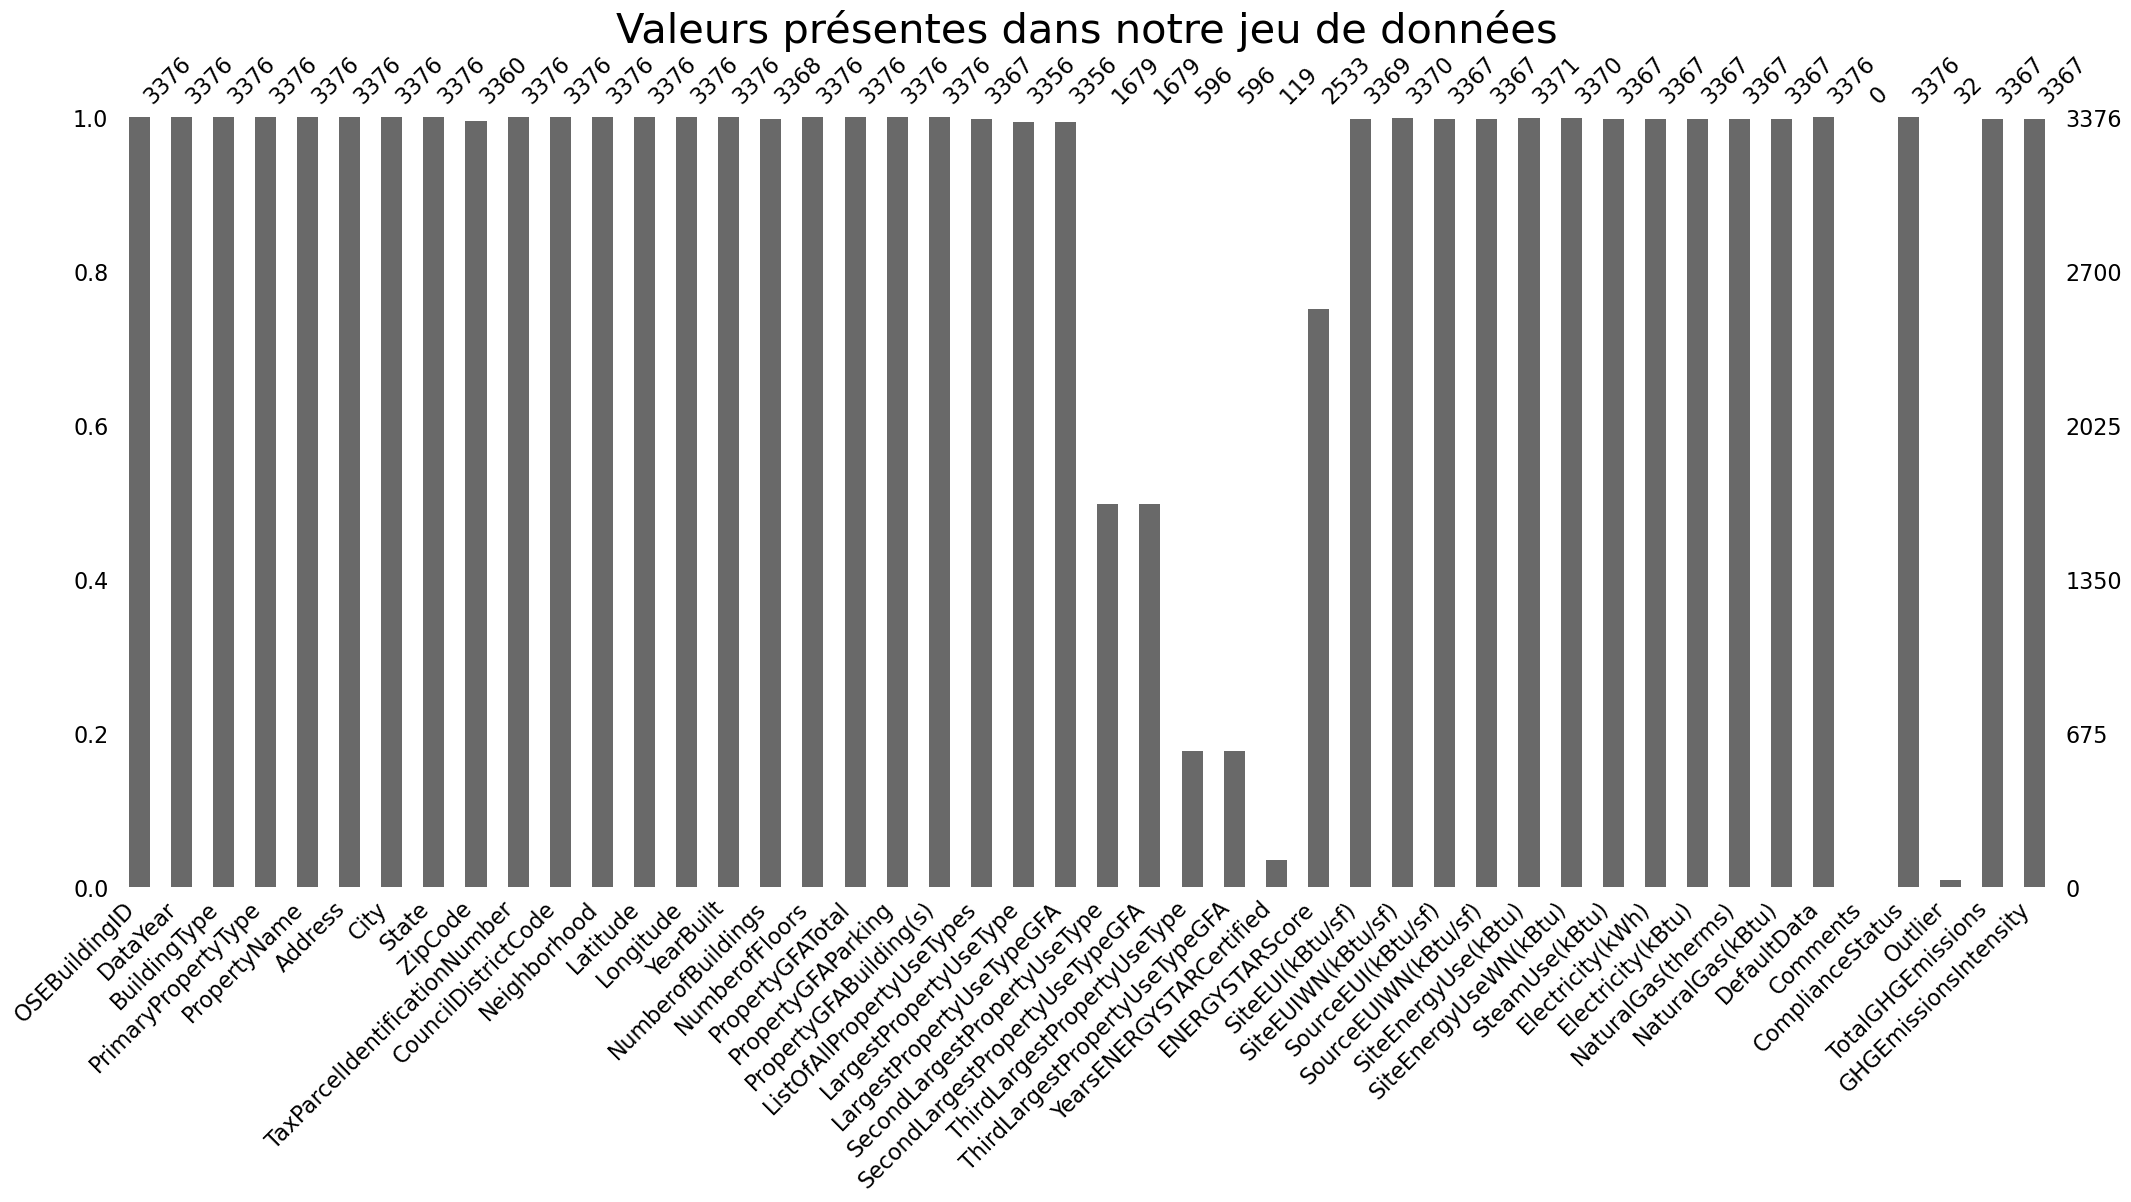

In [14]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(data)

<Axes: >

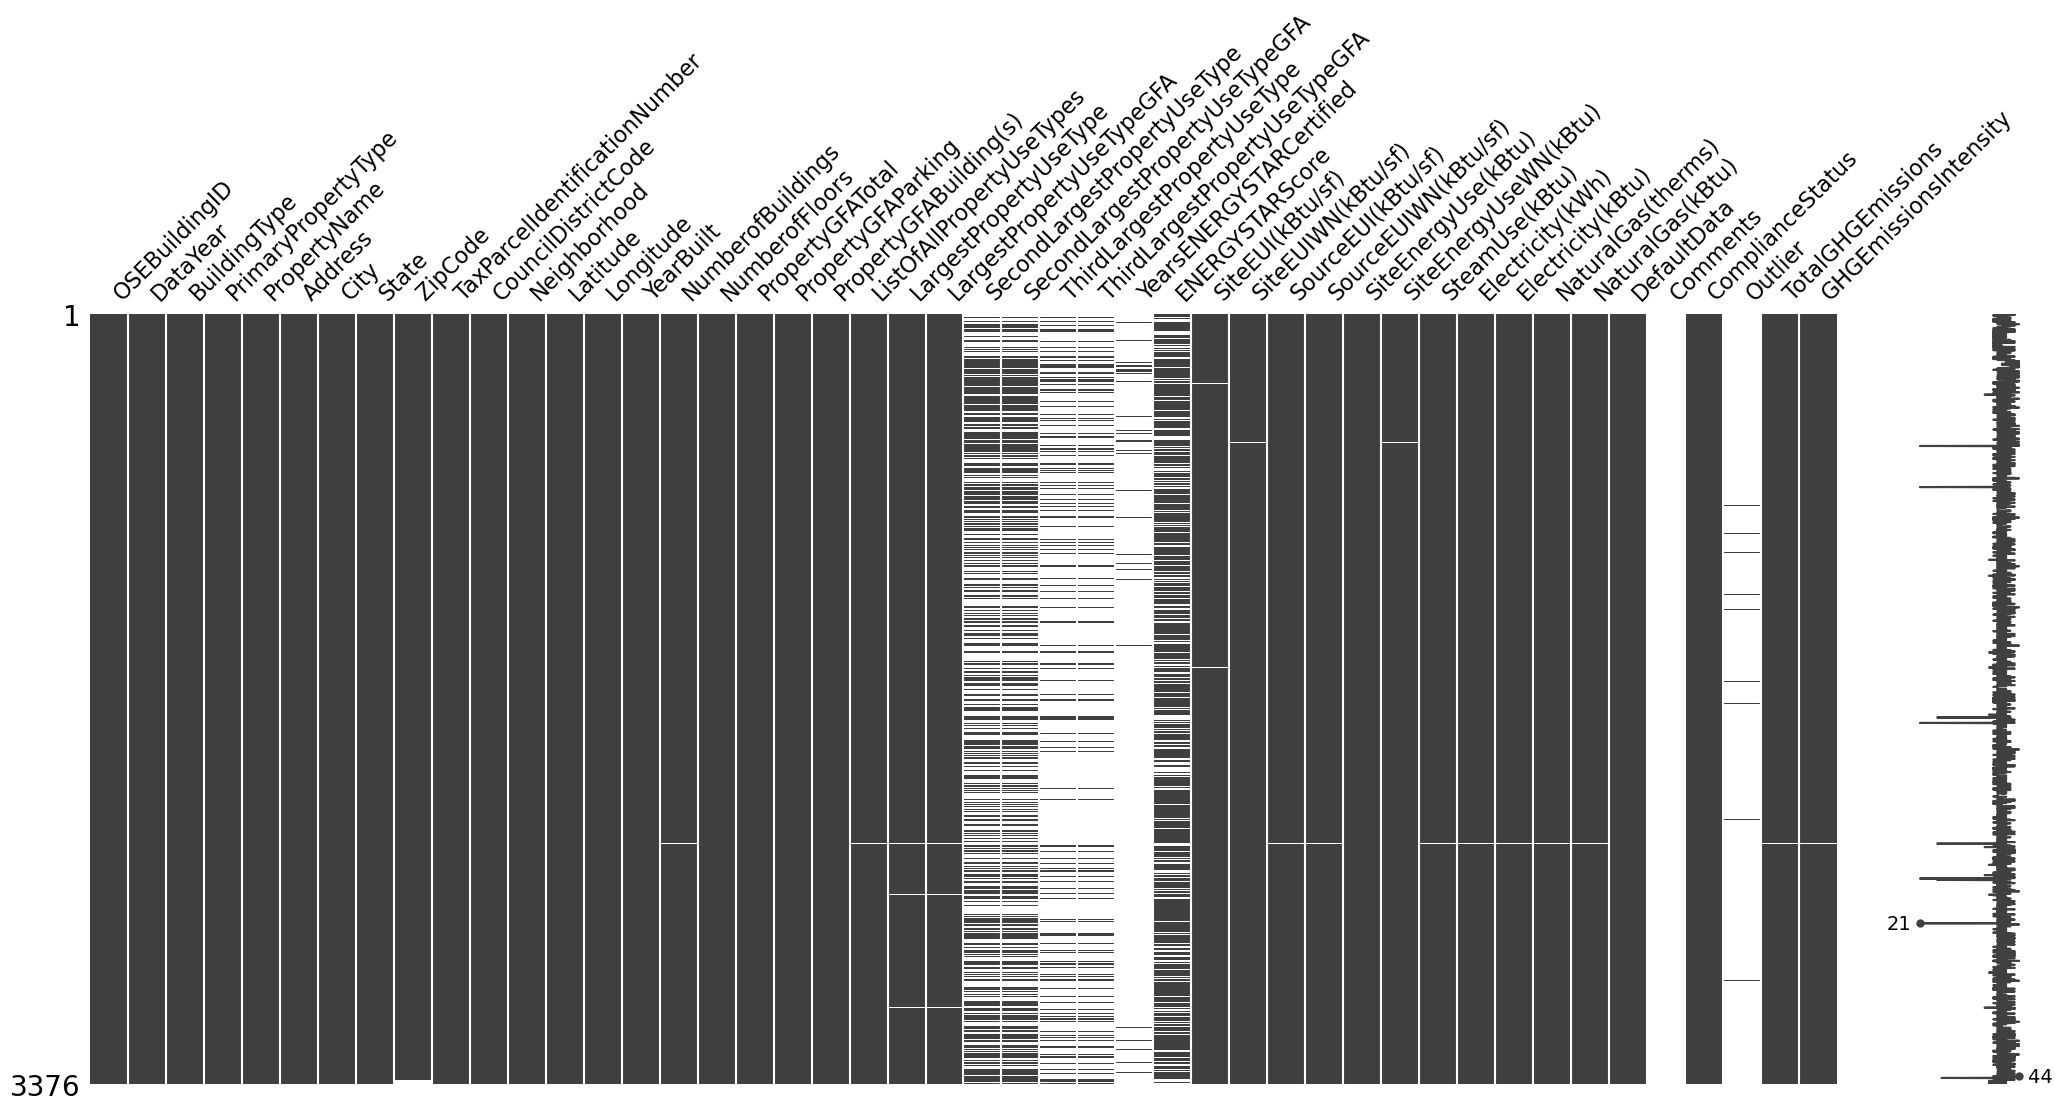

In [15]:
msno.matrix(data)

<Axes: >

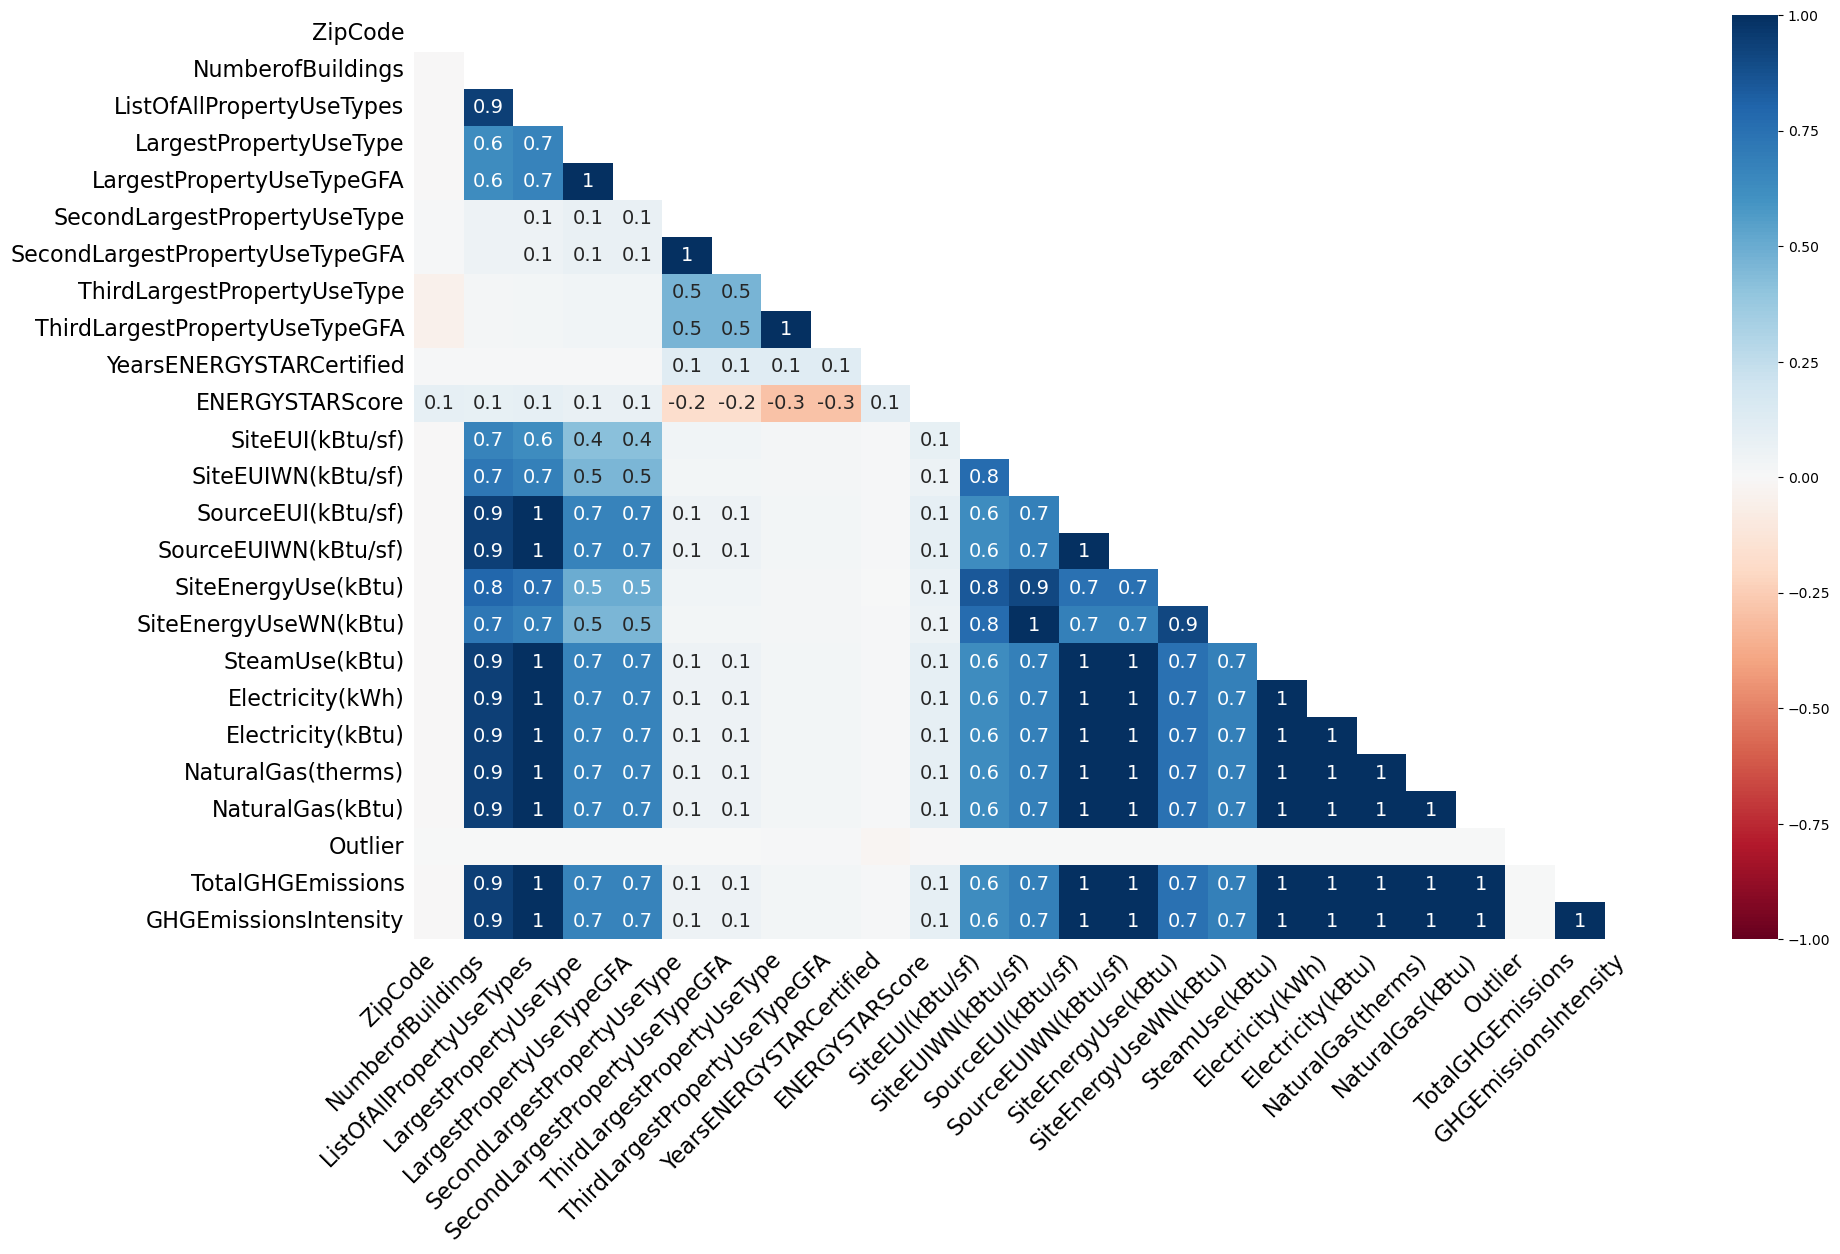

In [16]:
msno.heatmap(data)

## Compréhension des Variables

Différents groupes de variables :<br>

- Identification :<br>
OSEBuildingID
PropertyName
TaxParcelIdentificationNumber<br>
=> on les garde le temps de vérifier les doublons

- Localisation :<br>
Address, ZipCode, City, State
CouncilDistrictCode
Neighborhood
Latitude, longitude
=> on garde adresse et zipcode pour vérifier les outliers manuellement<br>
=> City et State ont des valeurs uniques => supprimés<br>
=> Latitude, longitude pour vérifier les outliers<br>
=> Zipcode, CouncilDistrictCode Neighborhood => On choisi Neighborhood car pas de valeurs manquantes et plus de catégories<br>

- Type de batiment/utilisation :<br>
BuildingType
ListOfAllPropertyUseTypes 	
PrimaryPropertyType
LargestPropertyUseType, SecondLargestPropertyUseType, ThirdLargestPropertyUseType<br>
=> on garde tout pour le moment même si primarypropertytype et largestpropertytype semblent similaires<br>

- Surface :<br>
PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s)<br>
LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA<br>
=> on garde tout <br>

- Energie :<br>
SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf) 	
SiteEnergyUse(kBtu), **SiteEnergyUseWN(kBtu)**
SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms),  NaturalGas(kBtu)<br>
=> on conserve tout pour les vérifications des valeurs mais on ne conservera pas les fuites de données par la suite<br>

- GES :<br>
**TotalGHGEmissions**, GHGEmissionsIntensity<br>
=> On garde tout pour le moment

- Bâtiment :<br>
YearBuilt
NumberofBuildings
NumberofFloors<br>
=> on garde tout <br>

- Energystarscore :<br>
YearsENERGYSTARCertified
**ENERGYSTARScore**<br>
=> on garde seulement l'EnergyStarScore, il y a trop de valeurs manquantes pour l'année<br>

- Autre :<br>
DefaultData
Comments 
ComplianceStatus
Outlier<br>
=> Comments à supprimer car vide, les autres à regarder en détail

In [17]:
cols_to_drop = ['DataYear', 'City', 'State', 'CouncilDistrictCode', 'TaxParcelIdentificationNumber', 
                'YearsENERGYSTARCertified', 'Comments']

# Liste de toutes les colonnes à conserver
cols_to_keep = data.columns.difference(cols_to_drop)

# Nettoyage des Données

## Format des données

In [18]:
data[cols_to_keep].dtypes

Address                             object
BuildingType                        object
ComplianceStatus                    object
DefaultData                           bool
ENERGYSTARScore                    float64
Electricity(kBtu)                  float64
Electricity(kWh)                   float64
GHGEmissionsIntensity              float64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
Latitude                           float64
ListOfAllPropertyUseTypes           object
Longitude                          float64
NaturalGas(kBtu)                   float64
NaturalGas(therms)                 float64
Neighborhood                        object
NumberofBuildings                  float64
NumberofFloors                       int64
OSEBuildingID                        int64
Outlier                             object
PrimaryPropertyType                 object
PropertyGFABuilding(s)               int64
PropertyGFAParking                   int64
PropertyGFA

## Recherche des doublons

In [19]:
nb_doublons_code = data.duplicated(subset=["OSEBuildingID"]).sum()
print('Nombre de doublons sur le OSEBuildingID :', nb_doublons_code)

Nombre de doublons sur le OSEBuildingID : 0


In [20]:
nb_doublons_add = data.duplicated(subset=['Address', 'PropertyName']).sum()
print('Nombre de doublons sur l\'adresse :', nb_doublons_add)

Nombre de doublons sur l'adresse : 0


## Vérification des données

In [21]:
df = data.copy()

In [22]:
selected_rows = df[df['PropertyGFATotal'].isin([230880, 299070, 428347, 1592914, 345290])]
selected_rows[['PropertyGFATotal', 'SiteEnergyUseWN(kBtu)', 'ListOfAllPropertyUseTypes', 'PrimaryPropertyType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']]

PropertyGFATotal  SiteEnergyUseWN(kBtu)  \
119             299070             66000296.0   
187             230880             61674856.0   
490            1592914             56785916.0   
3261            428347             38977108.0   
3356            345290             41078600.0   

                              ListOfAllPropertyUseTypes PrimaryPropertyType  \
119                                               Other               Other   
187                                               Other               Other   
490   Data Center, Financial Office, Office, Parking...        Large Office   
3261                                 College/University          University   
3356  Data Center, Laboratory, Museum, Office, Other...  Mixed Use Property   

     SecondLargestPropertyUseType ThirdLargestPropertyUseType  
119                           NaN                         NaN  
187                           NaN                         NaN  
490                       Parking            Financial Office  
3261                          NaN                         NaN  
3356                       Office                     Parking

In [23]:
selected_rows = df[df['PropertyGFATotal'].isin([299070, 345290, 428347])]
selected_rows[['PropertyGFATotal', 'TotalGHGEmissions', 'ListOfAllPropertyUseTypes', 'PrimaryPropertyType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']]

PropertyGFATotal  TotalGHGEmissions  \
119             299070            2055.82   
3261            428347            1280.81   
3356            345290            1000.06   

                              ListOfAllPropertyUseTypes PrimaryPropertyType  \
119                                               Other               Other   
3261                                 College/University          University   
3356  Data Center, Laboratory, Museum, Office, Other...  Mixed Use Property   

     SecondLargestPropertyUseType ThirdLargestPropertyUseType  
119                           NaN                         NaN  
3261                          NaN                         NaN  
3356                       Office                     Parking

In [24]:
def find_outliers(df, outlier_var, iqr_multiplier):
    # Calculer les limites de l'IQR pour chaque groupe
    q1 = df[outlier_var].quantile(0.25)
    q3 = df[outlier_var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Filtrer les outliers
    outliers = df[(df[outlier_var] < lower_bound) | (df[outlier_var] > upper_bound)]
    return outliers

In [25]:
def find_outliers_by_group(df, groupby_var, outlier_var, iqr_multiplier):
    # Calculer les limites de l'IQR pour chaque groupe
    q1 = df.groupby(groupby_var)[outlier_var].quantile(0.25)
    q3 = df.groupby(groupby_var)[outlier_var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Initialiser une liste pour stocker les DataFrame des outliers
    outliers_list = []

    # Identifier les outliers pour chaque groupe
    for group in df[groupby_var].dropna().unique():
        lower_bound_group = lower_bound.get(group, np.nan)
        upper_bound_group = upper_bound.get(group, np.nan)
        # Utiliser les valeurs obtenues pour filtrer les outliers, en vérifiant aussi que les bornes ne sont pas NaN
        if not np.isnan(lower_bound_group) and not np.isnan(upper_bound_group):
            outliers_group = df[(df[groupby_var] == group) & 
                                ((df[outlier_var] < lower_bound_group) | 
                                 (df[outlier_var] > upper_bound_group))]
            if not outliers_group.empty:
                outliers_list.append(outliers_group)

    # Concaténer les DataFrame des outliers, en vérifiant d'abord si la liste n'est pas vide
    if outliers_list:
        outliers = pd.concat(outliers_list)
        return outliers
    else:
        return pd.DataFrame()  # Retourner un DataFrame vide si aucun outlier n'est trouvé

### BuildingType

In [26]:
print("Valeurs uniques pour BuildingType dans data:", data['BuildingType'].unique())

Valeurs uniques pour BuildingType dans data: ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']


In [27]:
df = df[~df['BuildingType'].str.contains("Multifamily", na=False)].copy()

In [28]:
df.shape

(1668, 46)

### ComplianceStatus

In [29]:
print(df['ComplianceStatus'].value_counts())

ComplianceStatus
Compliant                       1548
Error - Correct Default Data      88
Non-Compliant                     18
Missing Data                      14
Name: count, dtype: int64


ComplianceStatus :

    - Non-Compliant indique que le bâtiment n'a pas satisfait certaines exigences de reporting ou de performance, ce qui pourrait signifier que les données associées sont incomplètes ou peu fiables.
    - Les bâtiments avec des erreurs dans leur statut de conformité ("Error") peuvent également souffrir de problèmes de données qui compromettent leur utilité pour l'analyse et la modélisation.
    
Inclure ces bâtiments pourrait introduire un biais ou de l'incertitude dans vos analyses.<br>
=> Suppression, On conserve les Compliant et Missing Data


In [30]:
df = df[~df['ComplianceStatus'].str.contains("Non-Compliant", na=False)].copy()
df = df[~df['ComplianceStatus'].str.contains("Error", na=False)].copy()
df = df.drop(columns=['ComplianceStatus'])

### DefaultData

In [31]:
print(df['DefaultData'].value_counts())

DefaultData
False    1562
Name: count, dtype: int64


Les valeurs par défaut peuvent avoir biaisé nos données, nous choisissons de supprimer ces batiments.

In [32]:
df = df[df['DefaultData'] != True]
df = df.drop(columns=['DefaultData'])

### Outlier

In [33]:
print("Valeurs uniques pour Outlier dans data:", data['Outlier'].unique())

Valeurs uniques pour Outlier dans data: [nan 'High outlier' 'Low outlier']


On conserve pour le moment pour vérifier s'il y a un impact sur nos modèles.

### Latitude et Longitude

Seattle :<br>
    - Longitude minimale : aux alentours de -122.436 (ouest)<br>
    - Longitude maximale : aux alentours de -122.255 (est)

In [34]:
# Définir les limites de longitude pour Seattle
longitude_min = -122.436
longitude_max = -122.255

# Sélectionner les lignes en dehors de cette fourchette de longitude
outliers_longitude = df[(df['Longitude'] < longitude_min) | (df['Longitude'] > longitude_max)]

# Afficher les valeurs aberrantes
outliers_longitude[['Address', 'Latitude', 'Longitude']]

Empty DataFrame
Columns: [Address, Latitude, Longitude]
Index: []

### Neighborhood

In [35]:
print("Valeurs uniques pour Neighborhood dans data:", df['Neighborhood'].unique())

Valeurs uniques pour Neighborhood dans data: ['DOWNTOWN' 'NORTHEAST' 'EAST' 'Central' 'MAGNOLIA / QUEEN ANNE'
 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD' 'NORTHWEST' 'CENTRAL'
 'SOUTHWEST' 'DELRIDGE' 'SOUTHEAST' 'NORTH' 'North' 'Delridge' 'Ballard'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']


In [36]:
# Corrections
df['Neighborhood'] = df['Neighborhood'].str.upper()
df['Neighborhood'] = df['Neighborhood'].str.replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
print("Valeurs uniques pour Neighborhood dans data:", df['Neighborhood'].unique())

Valeurs uniques pour Neighborhood dans data: ['DOWNTOWN' 'NORTHEAST' 'EAST' 'CENTRAL' 'MAGNOLIA / QUEEN ANNE'
 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD' 'NORTHWEST' 'SOUTHWEST'
 'DELRIDGE' 'SOUTHEAST' 'NORTH']


### NumberofBuildings

In [37]:
# Compter et trier le nombre de valeurs
NumberofBuildings_counts = df['NumberofBuildings'].value_counts().sort_index(ascending=False)

pd.DataFrame({'NumberofBuildings': NumberofBuildings_counts})

NumberofBuildings
NumberofBuildings                   
111.0                              1
27.0                               1
23.0                               1
14.0                               2
11.0                               1
10.0                               1
9.0                                1
8.0                                2
7.0                                1
6.0                                4
5.0                                7
4.0                                4
3.0                               12
2.0                               14
1.0                             1458
0.0                               52

Il y a forcément au moins 1 bâtiment par adresse, la valeur la plus fréquente étant 1 on remplace les 0 par 1

In [38]:
df.loc[df['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1.

Les adresses avec plus de 10 bâtiments sont à vérifier.

In [39]:
# Sélectionner les lignes où le nombre de bâtiments est supérieur à 10
buildings_over_10 = df[df['NumberofBuildings'] > 10]
buildings_over_10[['Address', 'ZipCode', 'NumberofBuildings', 'PrimaryPropertyType']]

Address  ZipCode  NumberofBuildings  \
105             6000 16th Ave SW  98106.0               27.0   
128           9600 COLLEGE WAY N  98103.0               11.0   
162               1420 S Trenton  98108.0               14.0   
1862  1900 West Nickerson Street  98119.0               23.0   
2325             3307 3rd Ave. W  98119.0               14.0   
3274   NE 45th St & Brooklyn Ave  98105.0              111.0   

     PrimaryPropertyType  
105           University  
128           University  
162         Large Office  
1862               Other  
2325          University  
3274          University

Nombre de batiments pas abérrants après vérifications sur google maps.

### NumberofFloors 

In [40]:
# Compter et trier le nombre de valeurs
NumberofFloors_counts = df['NumberofFloors'].value_counts().sort_index(ascending=False)

pd.DataFrame({'NumberofFloors': NumberofFloors_counts})

NumberofFloors
NumberofFloors                
99                           1
76                           1
63                           1
56                           1
55                           1
49                           1
47                           1
46                           1
42                           5
41                           2
39                           1
37                           1
36                           2
34                           2
33                           3
30                           1
29                           3
28                           1
27                           1
25                           3
24                           3
23                           3
22                           3
21                           3
20                           3
19                           5
18                           3
17                           4
16                           3
15                           6
14                           9
13                           7
12                           9
11                          18
10                          18
9                            8
8                           22
7                           33
6                           81
5                          102
4                          140
3                          247
2                          354
1                          429
0                           16

In [41]:
# Colonnes à afficher
cols_to_display = ['Address', 'NumberofFloors', 'PrimaryPropertyType']
print(df[cols_to_display].loc[df['NumberofFloors'] >60])

                       Address  NumberofFloors PrimaryPropertyType
233           700 Fifth Avenue              63        Large Office
559             701 5th Avenue              76        Large Office
1359  5801 Beacon Avenue South              99    Worship Facility


A corriger : <br>
    5801 Beacon Avenue South correspond à une église => remplacer par 1

In [42]:
df.loc[df['Address'] == '5801 Beacon Avenue South', 'NumberofFloors'] = 1

In [43]:
outliers = find_outliers_by_group(df, 'PrimaryPropertyType', 'NumberofFloors', 3)
if not outliers.empty:
    display(outliers[['Address', 'NumberofFloors', 'PrimaryPropertyType', 'PropertyGFATotal']])
else:
    print("Aucun outlier trouvé.")

Address  NumberofFloors  \
2                       1900 5th Avenue              41   
13                         1113 6th Ave              33   
49                      1400 6th Avenue              34   
15                   1000 Fourth Avenue              11   
20                          516 3RD AVE              10   
21                          500 5TH AVE              19   
119                       1900 9th Ave.              11   
187                        1122 3rd Ave              15   
298                          120 Lenora              12   
558                        2001 6th Ave              33   
246                      1220 HOWELL ST              11   
410              1200 12th Avenue South              14   
1773                 1500-1506 4th Ave.              11   
2314                      737 Olive Way              39   
2530  2201 9th Ave. / 820 Blanchard St.              19   
24                      1000 Lenora St.               7   
3095                     625 5th Ave. S              11   
475                    2203 1st Ave. S.               7   
233                    700 Fifth Avenue              63   
271                        1201 3rd ave              55   
292                       601 Union St.              56   
559                      701 5th Avenue              76   
496                    901 Boren Avenue              19   
561                       509 Olive Way              18   
205                     500 Pine Street              10   
302                     300 PINE STREET               8   
529                  619 Western Avenue               6   
186                     1118 5th Avenue               9   
952                   910 Marion Street              15   
156                      3613 4th Ave S               2   
412             7272 W. Marginal Way S.               2   
462                    270 S HANFORD ST               2   
467                      1000 1st Ave S               6   
468                      1014 1st Ave S               4   
537                      2700 4th Ave S               2   
1182             5615 W Marginal Way SW               2   
1582       1200-1210 West Nickerson st.               2   
2912                  1529 Fourth Ave W               3   
356              13000 Lake City Way NE               2   
638                1401 Broadway Avenue               3   
990              4545 Fauntleroy Way SW               2   
3116                  509-23 BROADWAY E               2   
3118                  500 Mercer Street               4   
3160                      516 1st Ave W               4   
3268                   5700 24th Ave NW               8   
3105                    1411 1st Avenue              13   

              PrimaryPropertyType  PropertyGFATotal  
2                           Hotel            956110  
13                          Hotel            315952  
49                          Hotel            994212  
15                          Other            412000  
20                          Other            540360  
21                          Other            385274  
119                         Other            299070  
187                         Other            230880  
298                         Other            193500  
558                         Other            429405  
246            Mixed Use Property            381381  
410            Mixed Use Property            304052  
1773           Mixed Use Property            111137  
2314           Mixed Use Property           1074552  
2530           Mixed Use Property           1206670  
24                     University            126593  
3095  Small- and Mid-Sized Office             68452  
475                     Warehouse            144050  
233                  Large Office           1354987  
271                  Large Office           1400000  
292                  Large Office           1605578  
559                  Large Office           1952220  
496             

Un restaurant avec 13 étage et après vérification sur la carte, cela semble être une erreur de saisie.
Mise à 0 temporaire pour lui appliquer la moyenne.<br>
Après vérification, les autres bâtiments ne sont pas des outliers.

In [44]:
df.loc[df['Address'] == '1411 1st Avenue', 'NumberofFloors'] = 0

Aux USA on compte le rez de chaussée comme un étage. Il y a donc necessairement au moins 1 étage par batiment.
Nous allons donc remplacer les valeurs à 0 par la moyenne en fonction de leur PrimaryPropertyType.

In [45]:
# Calculer la médiane du nombre d'étages pour chaque type de propriété et convertir en entiers
mean_floors_by_type = df[df['NumberofFloors'] > 0].groupby('PrimaryPropertyType')['NumberofFloors'].median().astype(int)


# Fonction pour remplacer les zéros par la moyenne correspondante
def replace_zero_with_mean(row):
    if row['NumberofFloors'] == 0:
        return mean_floors_by_type.get(row['PrimaryPropertyType'], 1)
    else:
        return row['NumberofFloors']


In [46]:
# Appliquer la fonction à la colonne 'NumberofFloors'
df['NumberofFloors'] = df.apply(replace_zero_with_mean, axis=1)

### YearBuilt

In [47]:
print("Valeurs uniques pour YearBuilt dans data:", df['YearBuilt'].unique())

Valeurs uniques pour YearBuilt dans data: [1927 1996 1969 1926 1980 1999 1904 1998 1928 1922 2004 1930 1983 1907
 1916 1985 2001 1991 1955 1978 1989 1906 1994 1992 1961 1990 1900 1954
 1911 1973 1920 1910 1982 1908 1959 2000 1997 1962 1970 2008 1948 1965
 1929 2010 1938 1986 2002 1923 2003 1941 2006 1915 1950 1958 2009 2011
 1971 2007 1951 1964 1953 1937 1966 1963 1957 1968 1924 2005 1931 1972
 1952 1914 1913 1995 1981 1925 1976 1909 1988 1979 1947 1984 1956 1912
 1977 1960 1945 1974 1975 1946 1967 1987 1949 1940 1932 1993 1918 1905
 1902 1921 1939 1944 1917 1942 1903 2012 2013 1919 1901 1936 1935 2014
 2015]


On remplace l'année de construction par l'âge du bâtiment au moment des relevés.

In [48]:
# Calculer l'âge des bâtiments et créer la colonne 'BuildingAge'
df['BuildingAge'] = 2016 - df['YearBuilt']

# Supprimer la colonne 'YearBuilt'
df.drop(columns=['YearBuilt'], inplace=True)

### Electricity

In [49]:
def check_electricity_coherence(row):
    # Pas d'évaluation si Electricity est nan
    if pd.isna(row['Electricity(kWh)']) or pd.isna(row['Electricity(kBtu)']):
        return False

    # Conversion: 1 kWh = 3.41214 kBtu
    electricity_kwh_to_btu = row['Electricity(kWh)'] * 3.41214

    # Calculer la marge de tolérance
    lower_bound = electricity_kwh_to_btu * 0.95
    upper_bound = electricity_kwh_to_btu * 1.15

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['Electricity(kBtu)'] <= upper_bound)

In [50]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_electricity_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 2


In [51]:
outliers[['Electricity(kBtu)','Electricity(kWh)']]

Electricity(kBtu)  Electricity(kWh)
1670                3.0           1.00000
3206          -115417.0      -33826.80078

In [52]:
# Suppression des outliers du DataFrame
df = df[df['is_outlier'] == False]

# Suppression de la colonne 'is_outlier'
df = df.drop(columns=['is_outlier'])

In [53]:
df['Electricity_per_GFA'] = df['Electricity(kBtu)'] / df['PropertyGFATotal']
outliers = find_outliers_by_group(df, 'PrimaryPropertyType', 'Electricity_per_GFA', 4)
if not outliers.empty:
    display(outliers[['Electricity_per_GFA','PrimaryPropertyType', 'LargestPropertyUseType', 
                      'SecondLargestPropertyUseType']])
else:
    print("Aucun outlier trouvé.")

Electricity_per_GFA          PrimaryPropertyType  \
240            834.402417                        Other   
329            293.115813                        Other   
558            639.332320                        Other   
3171           432.542734                        Other   
3203           459.650349                        Other   
35             304.093856           Mixed Use Property   
309            350.352853           Mixed Use Property   
373            225.894297           Mixed Use Property   
474            223.154322           Mixed Use Property   
954            153.846140                  K-12 School   
601            218.617755  Small- and Mid-Sized Office   
1262           193.041811  Small- and Mid-Sized Office   
1272           184.795893  Small- and Mid-Sized Office   
1405           151.075030  Small- and Mid-Sized Office   
2680           164.664949  Small- and Mid-Sized Office   
628            140.866293                    Warehouse   
2071           119.876513                    Warehouse   
2412           110.301817                    Warehouse   
328            167.310150                 Large Office   
512            168.008620                 Large Office   
516            154.308816                 Large Office   
641            156.143930                 Large Office   
3158           216.523894                 Large Office   
3279            77.869429               Residence Hall   
397            215.420718          Distribution Center   
3065           120.184463          Distribution Center   
1215            56.549319             Worship Facility   

                     LargestPropertyUseType SecondLargestPropertyUseType  
240                             Data Center                          NaN  
329     Urgent Care/Clinic/Other Outpatient                          NaN  
558                             Data Center                       Office  
3171    Urgent Care/Clinic/Other Outpatient                          NaN  
3203                            Data Center                      Parking  
35                                   Office                   Laboratory  
309                                 Parking                  Data Center  
373   Other - Entertainment/Public Assembly           Other - Recreation  
474                                 Parking                       Office  
954                             K-12 School                          NaN  
601                                  Office                          NaN  
1262                                 Office                        Other  
1272                                 Office                      Parking  
1405                                 Office                  Data Center  
2680                                 Office                   Laboratory  
628              Non-Refrigerated Warehouse                       Office  
2071             Non-Refrigerated Warehouse                       Office  
2412             Non-Refrigerated Warehouse                       Office  
328                                  Office                  Data Center  
512                                  Office                          NaN  
516                                  Office                      Parking  
641                                  Office                          NaN  
3158                                 Office             Other - Services  
3279               Residence Hall/Dormitory                          NaN  
397                     Distribution Center                          NaN  
3065                    Distribution Center                      Parking  
1215                       Worship Facility                      Parking

Pas abérrant pour un Data Center.

In [54]:
# Suppression de la colonne 'Electricity_per_GFA'
df = df.drop(columns=['Electricity_per_GFA'])

### NaturalGas

In [55]:
def check_natural_gas_coherence(row):
    # Pas d'évaluation si NaturalGas est nan
    if (pd.isna(row['NaturalGas(therms)']) or pd.isna(row['NaturalGas(kBtu)'])):
        return False
        
    # Conversion: 100 kBtu  = 1 therm
    natural_gas_therms_to_btu = row['NaturalGas(therms)'] * 100
    
    # Calculer la marge de tolérance
    lower_bound = natural_gas_therms_to_btu * 0.95
    upper_bound = natural_gas_therms_to_btu * 1.05

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['NaturalGas(kBtu)'] <= upper_bound)


In [56]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_natural_gas_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 0


In [57]:
# Suppression de la colonne 'is_outlier'
df = df.drop(columns=['is_outlier'])

In [58]:
df['NaturalGas_per_GFA'] = df['NaturalGas(kBtu)'] / df['PropertyGFATotal']
outliers = find_outliers_by_group(df, 'PrimaryPropertyType', 'NaturalGas_per_GFA', 4)
if not outliers.empty:
    display(outliers[['NaturalGas_per_GFA','PrimaryPropertyType', 'LargestPropertyUseType', 
                      'SecondLargestPropertyUseType']])
else:
    print("Aucun outlier trouvé.")

NaturalGas_per_GFA          PrimaryPropertyType  \
194           156.416576                        Hotel   
1279          255.621236                        Other   
2522          213.795469                        Other   
3365          306.377567                        Other   
3373          302.024706                        Other   
35            602.037043           Mixed Use Property   
47            197.791338           Mixed Use Property   
2380          255.155634           Mixed Use Property   
954           157.278651                  K-12 School   
1283           88.837891  Small- and Mid-Sized Office   
1785           92.699601  Small- and Mid-Sized Office   
2999          101.083597  Small- and Mid-Sized Office   
3132          116.210798  Small- and Mid-Sized Office   
3339           90.180912  Small- and Mid-Sized Office   
1044           55.774018        Self-Storage Facility   
162            24.360286                 Large Office   
235            22.429965                 Large Office   
256            36.169613                 Large Office   
281            31.975167                 Large Office   
320            61.868637                 Large Office   
443            46.729909                 Large Office   
512            42.058582                 Large Office   
3158           33.935427                 Large Office   
1690           92.353292               Medical Office   
136            97.514518                 Retail Store   
775           101.150298                 Retail Store   
1508           93.364732                 Retail Store   
2222          186.749122                 Retail Store   
3063           47.346920       Refrigerated Warehouse   

                     LargestPropertyUseType    SecondLargestPropertyUseType  
194                                   Hotel                             NaN  
1279                     Other - Recreation                             NaN  
2522                     Other - Recreation                             NaN  
3365                     Other - Recreation  Fitness Center/Health Club/Gym  
3373                     Other - Recreation  Fitness Center/Health Club/Gym  
35                                   Office                      Laboratory  
47    Other - Entertainment/Public Assembly                      Restaurant  
2380                             Restaurant                           Other  
954                             K-12 School                             NaN  
1283                                 Office                      Laboratory  
1785                                 Office                             NaN  
2999                                 Office                             NaN  
3132                                 Office                          Office  
3339                                 Office                             NaN  
1044                  Self-Storage Facility                             NaN  
162                                  Office                      Laboratory  
235                                  Office                         Parking  
256                                  Office                    Retail Store  
281                                  Office                    Retail Store  
320                                  Office                             NaN  
443                                  Office                      Restaurant  
512                                  Office                             NaN  
3158                                 Office                Other - Services  
1690                         Medical Office                         Parking  
136                            Retail Store                             NaN  
775                            Retail Store                           Other  
1508                           Retail Store                         Parking  
2222                           Retail Store       Supermarket/Grocery Store  
3063                 Refrigerated

Ces valeurs semblent plausibles donc on les laisse.

In [59]:
# Suppression de la colonne 'NaturalGas_per_GFA'
df = df.drop(columns=['NaturalGas_per_GFA'])

### SteamUse

In [60]:
df['SteamUse_per_GFA'] = df['SteamUse(kBtu)'] / df['PropertyGFATotal']
outliers = find_outliers_by_group(df, 'PrimaryPropertyType', 'SteamUse_per_GFA', 4)
if not outliers.empty:
    display(outliers[['SteamUse_per_GFA','PrimaryPropertyType', 'LargestPropertyUseType', 
                      'SecondLargestPropertyUseType']])
else:
    print("Aucun outlier trouvé.")

SteamUse_per_GFA          PrimaryPropertyType  \
0            22.659633                        Hotel   
2            22.556561                        Hotel   
3            36.112953                        Hotel   
10           34.193412                        Hotel   
11           18.006581                        Hotel   
12           25.478818                        Hotel   
13           13.729106                        Hotel   
14           52.834879                        Hotel   
19           32.877779                        Hotel   
49           11.666210                        Hotel   
262          52.440756                        Hotel   
272          53.296274                        Hotel   
280          46.936353                        Hotel   
964          34.409118                        Hotel   
975          31.956905                        Hotel   
2403         20.684389                        Hotel   
7            22.151268                        Other   
15            1.790193                        Other   
16           44.195008                        Other   
69           15.663625                        Other   
70           45.170425                        Other   
71           24.650492                        Other   
73           23.122692                        Other   
75           19.604118                        Other   
97           15.174713                        Other   
117          17.278298                        Other   
303           7.884756                        Other   
305          30.985113                        Other   
329          35.595406                        Other   
873          27.278733                        Other   
976          29.637227                        Other   
1155          7.458245                        Other   
1255        119.558115                        Other   
1257         17.930691                        Other   
1273         80.684221                        Other   
1277          8.363308                        Other   
1280          3.396552                        Other   
1291         28.738527                        Other   
1292          5.635568                        Other   
1753        180.934212                        Other   
2862          4.939136                        Other   
3182         69.345564                        Other   
18           30.916276           Mixed Use Property   
65           53.395495           Mixed Use Property   
301          15.097975           Mixed Use Property   
373         113.464477           Mixed Use Property   
3261         31.647751                   University   
3274          9.118435                   University   
2270         11.893594                  K-12 School   
199           8.721448  Small- and Mid-Sized Office   
208          32.904237  Small- and Mid-Sized Office   
216           3.890417  Small- and Mid-Sized Office   
223           5.278063  Small- and Mid-Sized Office   
452          11.044376  Small- and Mid-Sized Office   
780           7.576518  Small- and Mid-Sized Office   
806          10.216389  Small- and Mid-Sized Office   
1154         43.753037  Small- and Mid-Sized Office   
1156         72.322821  Small- and Mid-Sized Office   
1234         24.964220  Small- and Mid-Sized Office   
1294         18.825106  Small- and Mid-Sized Office   
1755         35.830388  Small- and Mid-Sized Office   
1779         29.779519  Small- and Mid-Sized Office   
2438         12.103461  Small- and Mid-Sized Office   
2439         17.411433  Small- and Mid-Sized Office   
2688          7.649096  Small- and Mid-Sized Office   
211          24.708698                 Large Office   
213          11.225712                 Large Office   
218           3.065671                 Large Office   
220          28.851637                 Large Office   
225           0.284481                 Large Office   
228          11.538259                 Large Office   
231           1.429507                 Large O

In [61]:
# Suppression de la colonne 'NaturalGas_per_GFA'
df = df.drop(columns=['SteamUse_per_GFA'])

### ListOfAllPropertyUseTypes

In [62]:
# Compter le nombre d'éléments dans chaque cellule de la colonne ListOfAllPropertyUseTypes avec gestion des valeurs NaN

# Étape préliminaire : Remplacer le cas particulier pour éviter le mauvais comptage
df['ListOfAllPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].apply(
    lambda x: x.replace('Personal Services (Health/Beauty, Dry Cleaning, etc)', 'PersonalServices') if pd.notna(x) else x)

df['NumberOfPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)

# Pour toutes les valeurs à 0 de NumberOfPropertyUseTypes, ajuster en fonction de l'existence de Third et SecondLargestPropertyUseType
for index, row in df.iterrows():
    if row['NumberOfPropertyUseTypes'] == 0:
        if row['ThirdLargestPropertyUseType'] != 'None':
            df.at[index, 'NumberOfPropertyUseTypes'] = 3
        if row['SecondLargestPropertyUseType'] != 'None':
            df.at[index, 'NumberOfPropertyUseTypes'] = 2
        else:
            df.at[index, 'NumberOfPropertyUseTypes'] = 1

# Supprimer l'ancienne colonne
if 'ListOfAllPropertyUseTypes' in df.columns:
    df = df.drop(columns=['ListOfAllPropertyUseTypes'])

### GHGEmissions

In [63]:
def check_TotalGHGEmissions(row):
    # Pas d'évaluation si TotalGHGEmissions est nan
    if (pd.isna(row['TotalGHGEmissions']) or pd.isna(row['GHGEmissionsIntensity'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['GHGEmissionsIntensity'] * 0.9 * row['PropertyGFATotal'] / 1000 # /1000 pour la conversion d'unité
    upper_bound = row['GHGEmissionsIntensity'] * 1.1 * row['PropertyGFATotal'] / 1000

    # La condition vérifie si la valeur est hors de la marge de tolérance
    return not(lower_bound <= row['TotalGHGEmissions'] <= upper_bound)

In [64]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_TotalGHGEmissions, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 7


In [65]:
# Créer une nouvelle colonne pour le calcul
copy_outliers = outliers.copy()
copy_outliers['Calculated_GHG'] = copy_outliers['GHGEmissionsIntensity'] * copy_outliers['PropertyGFATotal'] / 1000

copy_outliers[['GHGEmissionsIntensity', 'TotalGHGEmissions', 'Calculated_GHG', 'PropertyGFATotal', 'PrimaryPropertyType', 
               'LargestPropertyUseType', 'SecondLargestPropertyUseType']]

GHGEmissionsIntensity  TotalGHGEmissions  Calculated_GHG  \
34                     0.04               3.93         4.41424   
380                    0.02               3.25         2.60586   
595                    0.01               1.06         0.71718   
609                    0.02               4.20         3.41264   
1049                   0.03               1.67         1.49850   
1658                   0.03               0.86         1.00032   
1994                   0.04               1.14         1.03520   

      PropertyGFATotal    PrimaryPropertyType      LargestPropertyUseType  \
34              110356  Self-Storage Facility       Self-Storage Facility   
380             130293  Self-Storage Facility       Self-Storage Facility   
595              71718    Distribution Center         Distribution Center   
609             170632              Warehouse  Non-Refrigerated Warehouse   
1049             49950    Distribution Center         Distribution Center   
1658             33344  Self-Storage Facility       Self-Storage Facility   
1994             25880           Retail Store                Retail Store   

     SecondLargestPropertyUseType  
34                            NaN  
380                       Parking  
595                           NaN  
609                        Office  
1049                          NaN  
1658                       Office  
1994                          NaN

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [66]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

In [67]:
outliers = find_outliers_by_group(df, 'LargestPropertyUseType', 'GHGEmissionsIntensity', 4)
if not outliers.empty:
    display(outliers[['GHGEmissionsIntensity', 'TotalGHGEmissions', 'PropertyGFATotal', 'PrimaryPropertyType', 
               'LargestPropertyUseType', 'SecondLargestPropertyUseType']])
else:
    print("Aucun outlier trouvé.")

GHGEmissionsIntensity  TotalGHGEmissions  PropertyGFATotal  \
687                   10.41             416.07             39971   
954                    9.43             202.65             21500   
35                    34.09           16870.98            494835   
1156                   6.55             148.55             22667   
1283                   5.64             234.03             41466   
1785                   5.19             110.66             21315   
1970                   6.80             157.07             23100   
2439                   4.33             124.59             28760   
2999                   5.47             128.07             23422   
3132                   6.62             145.11             21931   
3339                   5.39             134.80             24990   
986                    9.11             188.67             20700   
1044                   3.00              65.65             21900   
136                    5.45             369.14             67745   
775                    5.96             154.17             25862   
1508                   5.55             215.56             38845   
2222                  10.90             413.10             37883   
3063                   5.23             119.76             22890   

              PrimaryPropertyType      LargestPropertyUseType  \
687                         Other                       Other   
954                   K-12 School                 K-12 School   
35             Mixed Use Property                      Office   
1156  Small- and Mid-Sized Office                      Office   
1283  Small- and Mid-Sized Office                      Office   
1785  Small- and Mid-Sized Office                      Office   
1970           Mixed Use Property                      Office   
2439  Small- and Mid-Sized Office                      Office   
2999  Small- and Mid-Sized Office                      Office   
3132  Small- and Mid-Sized Office                      Office   
3339  Small- and Mid-Sized Office                      Office   
986            Mixed Use Property  Non-Refrigerated Warehouse   
1044        Self-Storage Facility       Self-Storage Facility   
136                  Retail Store                Retail Store   
775                  Retail Store                Retail Store   
1508                 Retail Store                Retail Store   
2222                 Retail Store                Retail Store   
3063       Refrigerated Warehouse      Refrigerated Warehouse   

     SecondLargestPropertyUseType  
687                  Retail Store  
954                           NaN  
35                     Laboratory  
1156                          NaN  
1283                   Laboratory  
1785                          NaN  
1970      Other - Public Services  
2439                 Retail Store  
2999                          NaN  
3132                       Office  
3339                          NaN  
986                    Restaurant  
1044                          NaN  
136                           NaN  
775                         Other  
1508                      Parking  
2222    Supermarket/Grocery Store  
3063                       Office

In [68]:
len(outliers)

18

In [69]:
if not outliers.empty:
    df = df.drop(index=outliers.index)
else:
    df = df.copy()

### Energy

Somme pour arriver à SiteEnergyUse(kBtu)

In [70]:
def check_sum_energy(row):
    # Pas d'évaluation si SiteEnergyUseWN(kBtu) est nan ou 0
    if pd.isna(row['SiteEnergyUse(kBtu)']) | (row['SiteEnergyUse(kBtu)'] == 0):
        return False
    
    # Calculer la somme avec les valeurs manquantes remplacées temporairement par 0
    total_nrj_sum = (row['Electricity(kBtu)'] if pd.notna(row['Electricity(kBtu)']) else 0) + \
                    (row['SteamUse(kBtu)'] if pd.notna(row['SteamUse(kBtu)']) else 0) + \
                    (row['NaturalGas(kBtu)'] if pd.notna(row['NaturalGas(kBtu)']) else 0)

    # Calculer la marge de tolérance
    lower_bound = total_nrj_sum * 0.95
    upper_bound = total_nrj_sum * 1.05

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUse(kBtu)'] <= upper_bound)

In [71]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_sum_energy, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 17


In [72]:
# Afficher un échantillon des outliers
outliers[['SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']]

SiteEnergyUse(kBtu)  Electricity(kBtu)  SteamUse(kBtu)  NaturalGas(kBtu)
69           2.365898e+07         14419146.0       6093150.0          688680.0
71           2.095503e+07          7252325.0       9763690.0               0.0
73           2.726369e+06          1293349.0       1202380.0               0.0
75           2.072325e+07         13512686.0       5137220.0               0.0
403          9.058916e+06          7877393.0             0.0               0.0
513          1.252517e+07                0.0             0.0               0.0
563          5.177270e+06          4871126.0             0.0         1416041.0
601          3.795171e+07         18610055.0             0.0          685132.0
1280         2.485521e+06          1509514.0        137900.0          374537.0
1292         1.832809e+06          1110431.0        204650.0          391578.0
2037         2.107744e+06           786547.0             0.0         1028822.0
2441         2.092696e+06          1597575.0             0.0          991813.0
2761         9.772303e+05            90201.0             0.0          114794.0
2791         4.729846e+06          1323792.0             0.0               0.0
3274         8.739237e+08        657074389.0      84985240.0               0.0
3275         5.000717e+06          3719217.0             0.0               0.0
3277         5.116831e+07         28614613.0             0.0               0.0

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [73]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

#### Outliers

Pour ne pas introduire de biais nous préférons supprimer ces valeurs plutot que de les calculer

In [74]:
df = df[df['SiteEnergyUseWN(kBtu)'] > 0]

In [75]:
outliers = find_outliers_by_group(df, 'LargestPropertyUseType', 'SiteEUIWN(kBtu/sf)', 2.5)
if not outliers.empty:
    display(outliers[['SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'PrimaryPropertyType', 'LargestPropertyUseType', 'PropertyGFATotal']])
else:
    print("Aucun outlier trouvé.")

SiteEnergyUseWN(kBtu)  SiteEUIWN(kBtu/sf)          PrimaryPropertyType  \
194              26122018.0          213.600006                        Hotel   
47               15683742.0          299.000000           Mixed Use Property   
830               2622096.5          248.100006           Mixed Use Property   
106              16274449.0          167.399994  Small- and Mid-Sized Office   
162              54136068.0          161.899994                 Large Office   
253              29949248.0          161.199997                 Large Office   
320              11672252.0          184.699997                 Large Office   
328              48037000.0          174.600006                 Large Office   
441              22846738.0          235.600006           Mixed Use Property   
482               8570571.0          150.300003  Small- and Mid-Sized Office   
512              22571400.0          214.800003                 Large Office   
516              25478086.0          231.399994                 Large Office   
641              17877436.0          273.200012                 Large Office   
1262              5355753.0          193.000000  Small- and Mid-Sized Office   
1272              7419337.0          197.899994  Small- and Mid-Sized Office   
1405              7588115.5          199.300003  Small- and Mid-Sized Office   
2680              6197824.5          221.399994  Small- and Mid-Sized Office   
3158             41225944.0          255.399994                 Large Office   
628              14128860.0          200.699997                    Warehouse   
1109             12805711.0          355.700012        Senior Care Community   
65               15684371.0          207.300003           Mixed Use Property   
483              19892050.0          210.000000               Medical Office   
113               2220796.5           25.000000                        Other   
397              21341708.0          211.100006          Distribution Center   
3065              4403066.5          155.500000          Distribution Center   
309              75073888.0          707.299988           Mixed Use Property   
474              63172816.0          362.600006           Mixed Use Property   
809              33092532.0          693.099976                   Laboratory   
502              21406232.0          199.300003                        Other   

                     LargestPropertyUseType  PropertyGFATotal  
194                                   Hotel            122309  
47    Other - Entertainment/Public Assembly             52549  
830                     Social/Meeting Hall             33792  
106                                  Office             96300  
162                                  Office            334368  
253                                  Office            253103  
320                                  Office            103697  
328                                  Office            287819  
441                                  Office            175918  
482                                  Office             91706  
512                                  Office            105100  
516                                  Office            165111  
641                                  Office            113944  
1262                                 Office             27744  
1272                                 Office             37740  
1405                                 Office             43183  
2680                                 Office             37639  
3158                                 Office            162157  
628              Non-Refrigerated Warehouse             70400  
1109                  Senior Care Community             34636  
65                           Medical Office             99780  
483                          Medical Office            129093  
113             Other - Lodging/Residential             89821  
397                     Distribution Center            101101  
3065 

In [76]:
len(outliers)

29

In [77]:
if not outliers.empty:
    df = df.drop(index=outliers.index)
else:
    df = df.copy()

#### Cohérance SiteEnergyUseWN(kBtu) et SiteEnergyUse(kBtu)

In [78]:
def check_SiteEnergyUse_coherence(row):
    # Pas d'évaluation si SiteEnergyUse est nan
    if (pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['SiteEnergyUse(kBtu)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEnergyUse(kBtu)'] * 0.8
    upper_bound = row['SiteEnergyUse(kBtu)'] * 1.2

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUseWN(kBtu)'] <= upper_bound)

In [79]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_SiteEnergyUse_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 7


In [80]:
outliers[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)','PrimaryPropertyType', 'LargestPropertyUseType',
         'Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']]

SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu) PrimaryPropertyType  \
98           6.809073e+07           4.760272e+07            Hospital   
1043         1.257034e+06           1.510110e+06           Warehouse   
1429         6.757729e+05           8.194931e+05           Warehouse   
2411         1.887457e+05           2.318471e+05               Other   
2606         5.888561e+05           7.230602e+05           Warehouse   
2897         9.642360e+05           1.172287e+06    Worship Facility   
3032         3.481728e+06           4.195550e+06    Worship Facility   

                     LargestPropertyUseType  Electricity(kBtu)  \
98    Hospital (General Medical & Surgical)         35237205.0   
1043             Non-Refrigerated Warehouse           436193.0   
1429             Non-Refrigerated Warehouse           171716.0   
2411                                  Other            64453.0   
2606             Non-Refrigerated Warehouse           193898.0   
2897                       Worship Facility           282478.0   
3032                       Worship Facility           751827.0   

      SteamUse(kBtu)  NaturalGas(kBtu)  
98               0.0        32853512.0  
1043             0.0          820840.0  
1429             0.0          504057.0  
2411             0.0          124293.0  
2606             0.0          394958.0  
2897             0.0          681758.0  
3032             0.0         2729901.0

Valeurs trop différentes on les considère comme outliers.

In [81]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

#### Cohérance pour SiteEUIWN(kBtu/sf) et SiteEnergyUseWN(kBtu)

In [82]:
def check_SiteEUI_SiteEnergyUse(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['SiteEUIWN(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEUIWN(kBtu/sf)'] * 0.9 * row['PropertyGFATotal']
    upper_bound = row['SiteEUIWN(kBtu/sf)'] * 1.1 * row['PropertyGFATotal']

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUseWN(kBtu)'] <= upper_bound)


In [83]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_SiteEUI_SiteEnergyUse, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 485


In [84]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
# Créer une nouvelle colonne pour le calcul
sample_outliers['Calculated_SiteEnergyUseWN(kBtu)'] = sample_outliers['SiteEUIWN(kBtu/sf)'] * sample_outliers['PropertyGFATotal']

# Sélectionner les colonnes d'intérêt pour l'affichage
calculated_vs_actual = sample_outliers[['Calculated_SiteEnergyUseWN(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'PropertyGFATotal']]

calculated_vs_actual

Calculated_SiteEnergyUseWN(kBtu)  SiteEnergyUseWN(kBtu)  \
785                       3.314354e+06           2.249630e+06   
76                        4.994496e+06           4.192108e+06   
193                       3.486500e+07           2.873150e+07   
2667                      1.577282e+06           1.181649e+06   
308                       1.073643e+08           5.507312e+07   
1161                      1.764602e+06           1.291405e+06   
567                       4.679543e+06           2.533838e+06   
209                       9.522735e+06           8.081443e+06   
40                        2.811639e+06           3.150636e+06   
2642                      2.393754e+06           1.620384e+06   

      SiteEUIWN(kBtu/sf)  PropertyGFATotal  
785            86.000000             38539  
76             75.400002             66240  
193           183.500000            190000  
2667           56.400002             27966  
308           283.700012            378443  
1161           52.299999             33740  
567            56.299999             83118  
209            46.500000            204790  
40             53.500000             52554  
2642           92.900002             25767

In [85]:
def adjust_SiteEUI_SiteEnergyUse(row):
    # Pas d'évaluation si SiteEnergyUseWN(kBtu) est nan
    if pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['PropertyGFATotal']) or row['PropertyGFATotal'] == 0:
        return row['SiteEUIWN(kBtu/sf)'] 
    
    # Calculer SiteEUIWN(kBtu/sf) attendu à partir de SiteEnergyUseWN(kBtu) et PropertyGFATotal
    expected_siteeui = row['SiteEnergyUseWN(kBtu)'] / row['PropertyGFATotal']
    
    # Calculer la marge de tolérance
    lower_bound = expected_siteeui * 0.95
    upper_bound = expected_siteeui * 1.05

    if not(lower_bound <= row['SiteEUIWN(kBtu/sf)'] <= upper_bound):
        return expected_siteeui  
    else:
        return row['SiteEUIWN(kBtu/sf)'] 

# Appliquer la fonction 
df['SiteEUIWN(kBtu/sf)'] = df.apply(adjust_SiteEUI_SiteEnergyUse, axis=1)

#### Cohérance pour SiteEUIWN(kBtu/sf) et SourceEUIWN(kBtu/sf)

cohérance pour SiteEUIWN(kBtu/sf) et SourceEUIWN(kBtu/sf)

In [86]:
def check_Source_Site_coherence(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SourceEUIWN(kBtu/sf)']) or pd.isna(row['SiteEUI(kBtu/sf)'])):
        return False

    return not(row['SourceEUIWN(kBtu/sf)'] > row['SiteEUI(kBtu/sf)'])

In [87]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_Source_Site_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 0


In [88]:
df = df.drop(columns=['is_outlier'])

#### Traitement des fuites de données

In [89]:
cols_energie = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

# Calcul du pourcentage d'utilisation pour chaque type d'énergie
for col in cols_energie:
    new_col_name = col.replace('(kBtu)', '') + '_pct'
    df[new_col_name] = (df[col] / df['SiteEnergyUseWN(kBtu)']) * 100

# Régulation pour que la somme des nouvelles colonnes ne dépasse pas 100
sum_values = df[[col.replace('(kBtu)', '') + '_pct' for col in cols_energie]].sum(axis=1)
mask = sum_values > 100

# Correction de la régulation pour chaque nouvelle colonne de pourcentage
for col in [col.replace('(kBtu)', '') + '_pct' for col in cols_energie]:
    df.loc[mask, col] = df.loc[mask, col] * (100 / sum_values[mask])

# supprimer les colonnes des énergies en kBtu
df = df.drop(columns=cols_energie).copy()

### PropertyUseType

In [90]:
# Vérification des PrimaryPropertyType
print("Valeurs uniques pour PrimaryPropertyType dans data:", df['PrimaryPropertyType'].unique())

Valeurs uniques pour PrimaryPropertyType dans data: ['Hotel' 'Other' 'Mixed Use Property' 'University'
 'Small- and Mid-Sized Office' 'Warehouse' 'K-12 School'
 'Self-Storage Facility' 'Large Office' 'Senior Care Community'
 'Medical Office' 'Retail Store' 'Residence Hall' 'Hospital'
 'Distribution Center' 'Worship Facility' 'Supermarket / Grocery Store'
 'Laboratory' 'Refrigerated Warehouse' 'Restaurant' 'Low-Rise Multifamily']


In [91]:
df = df[~df['PrimaryPropertyType'].str.contains("Multifamily", na=False)].copy()
df = df[~df['PrimaryPropertyType'].str.contains("Residence Hall", na=False)].copy()

In [92]:
# Vérification des LargestPropertyUseType
print("Valeurs uniques pour LargestPropertyUseType dans data:", df['LargestPropertyUseType'].unique())

Valeurs uniques pour LargestPropertyUseType dans data: ['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Library' 'Fitness Center/Health Club/Gym' 'Social/Meeting Hall'
 'Courthouse' 'Other' 'College/University' 'Automobile Dealership'
 'Office' 'Non-Refrigerated Warehouse' 'K-12 School'
 'Self-Storage Facility' 'Other - Mall' 'Senior Care Community'
 'Medical Office' 'Retail Store' 'Museum'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Other/Specialty Hospital' 'Hospital (General Medical & Surgical)'
 'Financial Office' 'Distribution Center' 'Parking' 'Multifamily Housing'
 'Worship Facility' 'Restaurant' 'Data Center' 'Laboratory'
 'Supermarket/Grocery Store' 'Urgent Care/Clinic/Other Outpatient' nan
 'Other - Services' 'Strip Mall' 'Wholesale Club/Supercenter'
 'Refrigerated Warehouse' 'Manufacturing/Industrial Plant'
 'Other - Recreation' 'Lifestyle Center' 'Other - Public Services'
 'Fire Station' 'Performing Arts' 'Residential Care Facility'
 'Bank Branch

In [93]:
df = df[~df['LargestPropertyUseType'].str.contains("Residence Hall/Dormitory", na=False)].copy()
df = df[~df['LargestPropertyUseType'].str.contains("Lodging", na=False)].copy()
df = df[~df['LargestPropertyUseType'].str.contains("Multifamily", na=False)].copy()

Remplir les nan et mettre plus de précision dans les noms des LargestPropertyUseType (Large et Small Office)

In [94]:
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna(df['PrimaryPropertyType'])
df.loc[df['LargestPropertyUseType'] == 'Office', 'LargestPropertyUseType'] = df['PrimaryPropertyType']
df.loc[df['PrimaryPropertyType'] == 'University', 'LargestPropertyUseType'] = df['PrimaryPropertyType']

In [95]:
def adjust_property_use_type(row):    
    if pd.isna(row['SecondLargestPropertyUseType']):
        row['SecondLargestPropertyUseType'] = "None"
    if pd.isna(row['ThirdLargestPropertyUseType']):
        row['ThirdLargestPropertyUseType'] = "None"
    return row

# Appliquer la fonction pour ajuster les valeurs de PropertyUseType sur le DataFrame complet
df = df.apply(adjust_property_use_type, axis=1)

In [96]:
# Vérification des LargestPropertyUseType
print("Valeurs uniques pour SecondLargestPropertyUseType dans data:", df['SecondLargestPropertyUseType'].unique())

Valeurs uniques pour SecondLargestPropertyUseType dans data: ['None' 'Parking' 'Office' 'Restaurant' 'K-12 School'
 'Refrigerated Warehouse' 'Non-Refrigerated Warehouse' 'Other - Education'
 'Vocational School' 'Retail Store'
 'Personal Services (Health/Beauty, Dry Cleaning, etc)'
 'Other - Entertainment/Public Assembly' 'Data Center' 'Swimming Pool'
 'Other' 'Courthouse' 'Residence Hall/Dormitory' 'Distribution Center'
 'Self-Storage Facility' 'Other - Services' 'Movie Theater'
 'Medical Office' 'Laboratory' 'Other - Recreation'
 'Convenience Store without Gas Station' 'Performing Arts'
 'College/University' 'Supermarket/Grocery Store' 'Other - Restaurant/Bar'
 'Adult Education' 'Enclosed Mall' 'Multifamily Housing' 'Bar/Nightclub'
 'Financial Office' 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Manufacturing/Industrial Plant' 'Other - Lodging/Residential'
 'Bank Branch' 'Fitness Center/Health Club/Gym' 'Hotel' 'Worship Facility'
 'Food Sales' 'Food Service' 'Pre-school/Daycare

In [97]:
# Vérification des LargestPropertyUseType
print("Valeurs uniques pour ThirdLargestPropertyUseType dans data:", df['ThirdLargestPropertyUseType'].unique())

Valeurs uniques pour ThirdLargestPropertyUseType dans data: ['None' 'Restaurant' 'Swimming Pool' 'Data Center' 'Office' 'Retail Store'
 'Other - Entertainment/Public Assembly' 'Other' 'Distribution Center'
 'Other - Services' 'Medical Office' 'Parking' 'Food Service'
 'K-12 School' 'Fitness Center/Health Club/Gym' 'Social/Meeting Hall'
 'Pre-school/Daycare' 'Convenience Store without Gas Station'
 'Financial Office' 'Non-Refrigerated Warehouse' 'Other - Restaurant/Bar'
 'Other - Education' 'Multifamily Housing' 'Laboratory' 'Bank Branch'
 'Hotel' 'Other - Recreation'
 'Personal Services (Health/Beauty, Dry Cleaning, etc)'
 'Self-Storage Facility' 'Other - Technology/Science'
 'Refrigerated Warehouse' 'Bar/Nightclub' 'Manufacturing/Industrial Plant'
 'Other/Specialty Hospital' 'Fast Food Restaurant' 'Worship Facility'
 'Supermarket/Grocery Store' 'Strip Mall' 'Vocational School']


In [98]:
# Concaténer les PropertyUseType
all_categories = pd.concat([df['LargestPropertyUseType'], df['SecondLargestPropertyUseType'], df['ThirdLargestPropertyUseType']])
unique_categories = all_categories.unique()
print(unique_categories)

['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Library' 'Fitness Center/Health Club/Gym' 'Social/Meeting Hall'
 'Courthouse' 'Other' 'University' 'Automobile Dealership'
 'Small- and Mid-Sized Office' 'Non-Refrigerated Warehouse' 'K-12 School'
 'Self-Storage Facility' 'Large Office' 'Other - Mall'
 'Senior Care Community' 'Medical Office' 'Retail Store' 'Museum'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Other/Specialty Hospital' 'Hospital (General Medical & Surgical)'
 'Financial Office' 'Distribution Center' 'Parking' 'Worship Facility'
 'Restaurant' 'Data Center' 'Laboratory' 'Supermarket/Grocery Store'
 'Mixed Use Property' 'Urgent Care/Clinic/Other Outpatient'
 'Other - Services' 'Strip Mall' 'Wholesale Club/Supercenter'
 'Refrigerated Warehouse' 'Manufacturing/Industrial Plant'
 'Other - Recreation' 'Lifestyle Center' 'Other - Public Services'
 'Fire Station' 'Performing Arts' 'Residential Care Facility'
 'Bank Branch' 'Other - Education' 'Other - R

Beaucoup de catégories, nous allons les regrouper en catégories plus générales.

**Création des catégories**

Observation du SiteEUIWN(kBtu/sf) uniquement pour les propriété à usage unique ou à plus de 95% afin de visualiser des comportements qui se détachent/regroupent.

In [99]:
# Créer un DataFrame intermédiaire qui filtre selon la condition
df_one_use_type = df[df['LargestPropertyUseTypeGFA'] >= 0.75 * df['PropertyGFATotal']]
df_one_use_type = df_one_use_type.copy()
df_one_use_type['EnergyUseIntensite'] = df['SiteEUIWN(kBtu/sf)'] * df['LargestPropertyUseTypeGFA'] / df['PropertyGFATotal']
df_one_use_type.shape

(983, 45)

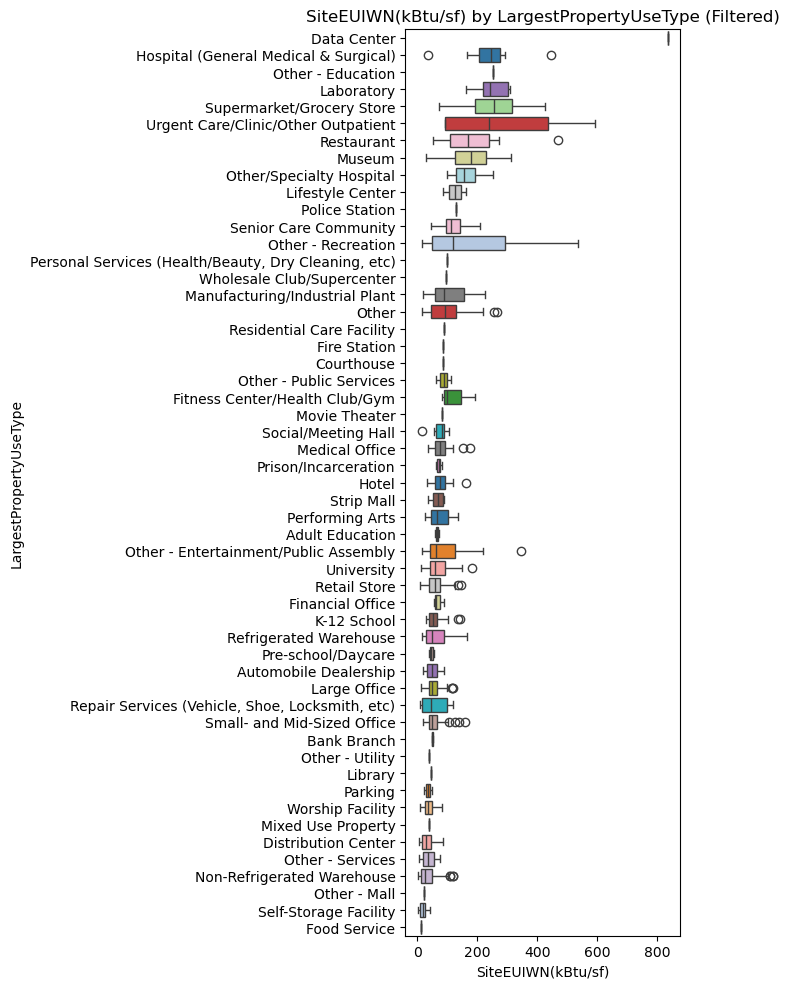

In [100]:
# Calculer l'ordre selon la médiane de SiteEUIWN(kBtu/sf) 
order_energy_filtered = df_one_use_type.groupby('LargestPropertyUseType')['EnergyUseIntensite'].median().sort_values(ascending=False).index

plt.figure(figsize=(7, 10))  
sns.boxplot(
    y='LargestPropertyUseType',
    x='SiteEUIWN(kBtu/sf)',
    data=df_one_use_type,  
    orient='h',
    order=order_energy_filtered, 
    palette="tab20",
    hue='LargestPropertyUseType'
)
plt.title('SiteEUIWN(kBtu/sf) by LargestPropertyUseType (Filtered)')
plt.xlabel('SiteEUIWN(kBtu/sf)')
plt.ylabel('LargestPropertyUseType')
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

In [101]:
summary_stats = df_one_use_type.groupby('LargestPropertyUseType')['SiteEUIWN(kBtu/sf)'].describe()
sorted_summary_stats = summary_stats.sort_values(by=('mean'), ascending=False)
sorted_summary_stats

count        mean  \
LargestPropertyUseType                                                  
Data Center                                           1.0  834.400024   
Urgent Care/Clinic/Other Outpatient                   4.0  291.499994   
Other - Education                                     1.0  252.100006   
Supermarket/Grocery Store                            32.0  250.342809   
Laboratory                                            5.0  247.204342   
Hospital (General Medical & Surgical)                 7.0  241.027953   
Restaurant                                            7.0  198.542859   
Museum                                                4.0  176.043859   
Other - Recreation                                   18.0  175.287715   
Other/Specialty Hospital                              4.0  166.491488   
Police Station                                        1.0  129.324398   
Lifestyle Center                                      2.0  125.591794   
Fitness Center/Health Club/Gym                        3.0  124.681742   
Senior Care Community                                14.0  119.351434   
Manufacturing/Industrial Plant                        7.0  110.025756   
Other                                                61.0   98.291470   
Other - Entertainment/Public Assembly                15.0   97.843559   
Personal Services (Health/Beauty, Dry Cleaning,...    1.0   97.800003   
Wholesale Club/Supercenter                            1.0   95.500000   
Residential Care Facility                             1.0   89.199997   
Other - Public Services                               2.0   87.715233   
Courthouse                                            1.0   87.500000   
Fire Station                                          1.0   86.199997   
Movie Theater                                         1.0   83.500000   
Medical Office                                       21.0   79.874340   
Performing Arts                                       3.0   76.691300   
Hotel                                                54.0   76.681087   
Prison/Incarceration                                  3.0   72.433334   
Social/Meeting Hall                                   6.0   72.223613   
Refrigerated Warehouse                                9.0   71.544443   
University                                           20.0   70.937682   
Financial Office                                      3.0   70.133335   
Strip Mall                                            4.0   66.518221   
Adult Education                                       2.0   65.249998   
Retail Store                                         63.0   61.939573   
Repair Services (Vehicle, Shoe, Locksmith, etc)       5.0   57.720000   
K-12 School                                          46.0   56.805969   
Large Office                                         84.0   55.558576   
Small- and Mid-Sized Office                         175.0   52.805611   
Automobile Dealership                                 4.0   51.474999   
Bank Branch                                           2.0   50.344689   
Pre-school/Daycare                                    2.0   47.100000   
Library                                               1.0   45.405126   
Other - Utility                                       1.0   40.200001   
Other - Services                                      3.0   38.956435   
Mixed Use Property                                    1.0   38.700001   
Worship Facility                                     61.0   38.438941   
Parking                                               7.0   36.124625   
Non-Refrigerated Warehouse                          149.0   34.521232   
Distribution Center                                  36.0   32.651539   
Other - Mall                                          1.0   21.600000   
Self-Storage Facility                                22.0   19.310734   
Food Service                                          1.0   12.700000   

                                    

In [102]:
def group_Type(type):
    type_to_category = {
        # Science Technologie
        'Data Center': 'Science_Technologie',
        'Laboratory': 'Science_Technologie',
        #'Other - Technology/Science': 'Science_Technologie',
        #Santé - Hôpitaux Généraux :
        'Hospital (General Medical & Surgical)': 'Sante',
        'Other/Specialty Hospital': 'Sante',
        'Urgent Care/Clinic/Other Outpatient': 'Sante',
        'Senior Care Community': 'Sante',
        # Supermarche
        'Supermarket/Grocery Store': 'Supermarche', 
        # Restauration et divertissements
        'Restaurant': 'Restauration_Divertissement', 
        'Other - Restaurant/Bar': 'Restauration_Divertissement', 
        'Fast Food Restaurant' : 'Restauration_Divertissement',
        'Food Sales': 'Restauration_Divertissement',
        'Bar/Nightclub': 'Restauration_Divertissement',
        'Museum': 'Restauration_Divertissement',
        'Other - Recreation': 'Restauration_Divertissement',
        # Éducation :
        'K-12 School': 'Education',
        'Pre-school/Daycare': 'Education',
        'University': 'Education',
        'College/University': 'Education',
        'Adult Education': 'Education',
        'Vocational School': 'Education',
        'Other - Education': 'Education',
        # Loisirs, Shopping et services personnels
        'Lifestyle Center': 'Loisirs_Shopping_ServicesPerso',
        'Fitness Center/Health Club/Gym': 'Loisirs_Shopping_ServicesPerso',
        'Other - Entertainment/Public Assembly': 'Loisirs_Shopping_ServicesPerso',
        'Movie Theater': 'Loisirs_Shopping_ServicesPerso',
        'Performing Arts': 'Loisirs_Shopping_ServicesPerso',
        'Swimming Pool': 'Loisirs_Shopping_ServicesPerso',
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Loisirs_Shopping_ServicesPerso',
        'Strip Mall': 'Loisirs_Shopping_ServicesPerso',
        'Wholesale Club/Supercenter': 'Loisirs_Shopping_ServicesPerso',
        'Enclosed Mall': 'Loisirs_Shopping_ServicesPerso',
        'Other - Mall': 'Loisirs_Shopping_ServicesPerso',
        # Commerce Detail
        'Retail Store': 'Commerce_detail',
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': 'Commerce_detail',
        'Automobile Dealership': 'Commerce_detail',
        'Convenience Store without Gas Station': 'Commerce_detail',
        # Autres Services 
        'Other - Utility': 'Autres_Services',
        'Parking': 'Autres_Services',
        'Other - Services': 'Autres_Services',
        'Worship Facility': 'Autres_Services',
        'Library': 'Autres_Services',
        'Police Station': 'Autres_Services',
        'Courthouse': 'Autres_Services',
        'Fire Station': 'Autres_Services',
        'Prison/Incarceration': 'Autres_Services',
        'Other - Public Services': 'Autres_Services',
        'Social/Meeting Hall': 'Autres_Services',
        # Bureau spécialisé
        'Medical Office': 'Bureau_specialise',
        'Financial Office': 'Bureau_specialise',
        # Bureaux
        'Bank Branch': 'Autres_Services',
        'Office': 'Bureau',
        'Small- and Mid-Sized Office': 'Bureau',
        'Large Office': 'Bureau',
        # Entrepot non refrigere
        'Distribution Center': 'Entrepot_nr',
        'Non-Refrigerated Warehouse': 'Entrepot_nr',
        'Self-Storage Facility': 'Entrepot_nr',
        # Résidences
        'Hotel': 'Residence',
        'Multifamily Housing' : 'Residence',
        'Other - Lodging/Residential': 'Residence',
        'Residence Hall/Dormitory': 'Residence',
        #'Residential Care Facility': 'Residence',
        # None
        'None': 'None'
    }

    return type_to_category.get(type, 'Autres')
  

In [103]:
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].apply(group_Type)
df['SecondLargestPropertyUseType'] = df['SecondLargestPropertyUseType'].apply(group_Type)
df['ThirdLargestPropertyUseType'] = df['ThirdLargestPropertyUseType'].apply(group_Type)

In [104]:
print(df['LargestPropertyUseType'].value_counts())

LargestPropertyUseType
Bureau                            424
Entrepot_nr                       265
Autres                            134
Autres_Services                   125
Commerce_detail                    98
Education                          77
Residence                          75
Restauration_Divertissement        51
Bureau_specialise                  43
Loisirs_Shopping_ServicesPerso     42
Supermarche                        40
Sante                              36
Science_Technologie                15
Name: count, dtype: int64


In [105]:
print(df['SecondLargestPropertyUseType'].value_counts())

SecondLargestPropertyUseType
None                              652
Autres_Services                   332
Bureau                            151
Commerce_detail                    84
Autres                             46
Restauration_Divertissement        37
Entrepot_nr                        37
Loisirs_Shopping_ServicesPerso     33
Residence                          14
Education                          12
Science_Technologie                12
Bureau_specialise                   9
Supermarche                         5
Sante                               1
Name: count, dtype: int64


In [106]:
print(df['ThirdLargestPropertyUseType'].value_counts())

ThirdLargestPropertyUseType
None                              1113
Autres_Services                     52
Bureau                              45
Commerce_detail                     45
Autres                              45
Restauration_Divertissement         37
Loisirs_Shopping_ServicesPerso      19
Entrepot_nr                         17
Education                           13
Residence                           13
Science_Technologie                 12
Bureau_specialise                   12
Sante                                1
Supermarche                          1
Name: count, dtype: int64


### GFA

On vérifie si PropertyGFATotal est supérieur ou égale à la somme de tous les GFA .

In [107]:
outliers = find_outliers_by_group(df, 'LargestPropertyUseType', 'PropertyGFATotal', 5)
if not outliers.empty:
    display(outliers[['PropertyGFATotal', 'PrimaryPropertyType', 
               'LargestPropertyUseType', 'SecondLargestPropertyUseType']])
else:
    print("Aucun outlier trouvé.")

PropertyGFATotal          PrimaryPropertyType  \
2               956110                        Hotel   
49              994212                        Hotel   
166             934292                        Hotel   
15              412000                        Other   
20              540360                        Other   
163             419848                        Other   
246             381381           Mixed Use Property   
308             378443           Mixed Use Property   
379             322869                        Other   
488             516407           Mixed Use Property   
599             361398                        Other   
3124            333698                        Other   
155            1585960                        Other   
158            1172127                        Other   
564             947987                        Other   
21              385274                        Other   
340             535947                        Other   
632             338063                        Other   
2530           1206670           Mixed Use Property   
105             441071                   University   
128             694072                   University   
137             367884                  K-12 School   
1494           2200000                   University   
2325            537000                   University   
3261            428347                   University   
121             530039                 Retail Store   
205             693450                 Retail Store   
302             861702                 Retail Store   
221            1323055                 Large Office   
229            1123435                 Large Office   
230            1052469                 Large Office   
233            1354987                 Large Office   
271            1400000                 Large Office   
273            1536606                 Large Office   
292            1605578                 Large Office   
477            1380959                 Large Office   
490            1592914                 Large Office   
559            1952220                 Large Office   
577            1249055                 Large Office   
36              714095                    Warehouse   
409             323916                    Warehouse   
603             411584          Distribution Center   
3130            384772                    Warehouse   
618            1765970                     Hospital   
3168            502030                        Other   
356             308965  Supermarket / Grocery Store   

              LargestPropertyUseType    SecondLargestPropertyUseType  
2                          Residence                            None  
49                         Residence                 Autres_Services  
166                        Residence                 Autres_Services  
15                   Autres_Services                 Autres_Services  
20                   Autres_Services                            None  
163                  Autres_Services  Loisirs_Shopping_ServicesPerso  
246                  Autres_Services                          Bureau  
308                  Autres_Services                          Bureau  
379                  Autres_Services                 Commerce_detail  
488                  Autres_Services                       Residence  
599                  Autres_Services                 Commerce_detail  
3124                 Autres_Services  Loisirs_Shopping_ServicesPerso  
155   Loisirs_Shopping_ServicesPerso                 Autres_Services  
158   Loisirs_Shopping_ServicesPerso                            None  
564   Loisirs_Shopping_ServicesPerso  Loisirs_Shopping_ServicesPerso  
21                            Autres                            None  
340                           Autres                 Autres_Services  
632                           Autres                 Commerce_detail  
2530                          Autres                       Residence  


In [108]:
def check_property_gfa(row):
    total_gfa_sum = (row['LargestPropertyUseTypeGFA'] if pd.notna(row['LargestPropertyUseTypeGFA']) else 0) + \
                (row['SecondLargestPropertyUseTypeGFA'] if pd.notna(row['SecondLargestPropertyUseTypeGFA']) else 0) + \
                (row['ThirdLargestPropertyUseTypeGFA'] if pd.notna(row['ThirdLargestPropertyUseTypeGFA']) else 0) + \
                (row['PropertyGFAParking'] if pd.notna(row['PropertyGFAParking']) else 0)

    # Calculer les marges de 20% pour plus ou moins
    lower_bound = total_gfa_sum * 0.8
    upper_bound = total_gfa_sum * 1.2
    
    # Vérifier si ThirdLargestPropertyUseType est None
    if row['ThirdLargestPropertyUseType'] != "None":
        # Si oui, vérifier seulement si PropertyGFATotal est inférieur au lower_bound
        return not (row['PropertyGFATotal'] >= lower_bound)
    else:
        # Sinon, vérifier si PropertyGFATotal est dans la marge de tolérance
        return not (lower_bound <= row['PropertyGFATotal'] <= upper_bound)


# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_property_gfa, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 290


In [109]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
sample_outliers[['PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PrimaryPropertyType', 'LargestPropertyUseTypeGFA', 
                 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']]

PropertyGFATotal  PropertyGFABuilding(s)  PropertyGFAParking  \
231             617684                  446184              171500   
335             139282                   86700               52582   
600              50785                   50785                   0   
332             184482                  118248               66234   
291             267335                  100375              166960   
1281             38038                   38038                   0   
2133             26853                   26853                   0   
3133             73102                   73102                   0   
1234             30525                   30525                   0   
2166             27227                   27227                   0   

              PrimaryPropertyType  LargestPropertyUseTypeGFA  \
231                  Large Office                   581558.0   
335                  Large Office                    79384.0   
600   Supermarket / Grocery Store                    27382.0   
332                  Large Office                   118016.0   
291                         Other                   166960.0   
1281  Small- and Mid-Sized Office                    38038.0   
2133                 Retail Store                    20360.0   
3133  Small- and Mid-Sized Office                    92723.0   
1234  Small- and Mid-Sized Office                    15609.0   
2166                        Other                    29064.0   

        SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
231                  Autres_Services                         189600.0   
335                  Autres_Services                          52582.0   
600                             None                              NaN   
332                  Autres_Services                          66234.0   
291   Loisirs_Shopping_ServicesPerso                          69947.0   
1281                 Autres_Services                          19600.0   
2133                            None                              NaN   
3133                 Autres_Services                          18364.0   
1234                 Commerce_detail                           6104.0   
2166  Loisirs_Shopping_ServicesPerso                           8508.0   

      ThirdLargestPropertyUseTypeGFA  
231                          18026.0  
335                           3027.0  
600                              NaN  
332                           1595.0  
291                          27400.0  
1281                             NaN  
2133                             NaN  
3133                             NaN  
1234                             NaN  
2166                           715.0

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [110]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

#### Completion à 0

In [111]:
# Fonction pour calculer la somme des GFA et comparer avec PropertyGFATotal
def adjust_gfa_values(row):
    # Calculer la somme des GFA, en remplaçant les NaN par 0
    gfa_sum = np.nansum([
        row.get('LargestPropertyUseTypeGFA', 0),
        row.get('SecondLargestPropertyUseTypeGFA', 0),
        row.get('ThirdLargestPropertyUseTypeGFA', 0),
        row.get('PropertyGFAParking', 0)
    ])
    
    # Calculer une marge de 5% pour PropertyGFATotal
    lower_bound = row['PropertyGFATotal'] * 0.9
    upper_bound = row['PropertyGFATotal'] * 1.1
    
    # Vérifier si la somme des GFA est dans la marge de 5% de PropertyGFATotal
    if lower_bound <= gfa_sum <= upper_bound:
        # Remplacer les NaN par 0 pour les colonnes spécifiées
        for col in ['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'PropertyGFAParking']:
            if pd.isna(row[col]):
                row[col] = 0
    return row


In [112]:
# Appliquer la fonction adjust_gfa_values à chaque ligne
df = df.apply(adjust_gfa_values, axis=1)

#### Calcul

In [113]:
def fill_missing_types_and_calculate_gfa(row):
    largest_gfa = row['LargestPropertyUseTypeGFA']
    second_largest_gfa = row.get('SecondLargestPropertyUseTypeGFA', 0)  # Utilise 0 si non défini
    parking_gfa = row['PropertyGFAParking']
    third_gfa = row.get('ThirdLargestPropertyUseTypeGFA', 0)  # Utilise 0 si non défini
    
    # Pour SecondLargestPropertyUseType
    if row['SecondLargestPropertyUseType'] == 'None':
        row['SecondLargestPropertyUseTypeGFA'] = 0

    # Calcul pour ThirdLargestPropertyUseType
    if row['ThirdLargestPropertyUseType'] == 'None':
        third_gfa_diff = row['PropertyGFATotal'] - largest_gfa - second_largest_gfa - parking_gfa
        if third_gfa_diff > 0:
            row['ThirdLargestPropertyUseType'] = "Autres" 
            row['ThirdLargestPropertyUseTypeGFA'] = third_gfa_diff
            third_gfa = third_gfa_diff  # Mise à jour de third_gfa
        else:
            row['ThirdLargestPropertyUseTypeGFA'] = 0

    # Vérification pour une différence restante après ThirdLargestPropertyUseType
    remaining_gfa_diff = row['PropertyGFATotal'] - largest_gfa - second_largest_gfa - parking_gfa - third_gfa
    if remaining_gfa_diff > 0:
        row['FourthLargestPropertyUseType'] = "Autres" 
        row['FourthLargestPropertyUseTypeGFA'] = remaining_gfa_diff
    else:
        row['FourthLargestPropertyUseType'] = "None" 
        row['FourthLargestPropertyUseTypeGFA'] = 0
    

    return row


In [114]:
# Appliquer la fonction pour ajuster les valeurs de Type et calculer les GFA
df = df.apply(fill_missing_types_and_calculate_gfa, axis=1)

#### Feature engineering

In [115]:
# Extraire les types et leurs GFA respectifs
types_columns = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'FourthLargestPropertyUseType']
gfa_columns = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'FourthLargestPropertyUseTypeGFA']

# Applatir le tableau et identifier tous les types d'utilisation uniques pour préparer les nouvelles colonnes
types_uniques = pd.unique(df[types_columns].values.ravel('K'))

# Initialiser les nouvelles colonnes pour chaque type unique dans le DataFrame original
for type_unique in types_uniques:
    if type_unique and type_unique != 'None':  # Ignorer les valeurs nulles ou 'None'
        df[f'GFA_{type_unique}'] = 0.0

# Parcourir chaque ligne et assigner les valeurs de GFA aux nouvelles colonnes
for index, row in df.iterrows():
    for type_col, gfa_col in zip(types_columns, gfa_columns):
        type_value = row[type_col]
        gfa_value = row[gfa_col]
        if type_value and type_value != 'None':  # S'assurer que le type est valide
            df.at[index, f'GFA_{type_value}'] += gfa_value

In [116]:
df.head(5)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
6             10      2016  NonResidential               Hotel   

              PropertyName          Address     City State  ZipCode  \
0     Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1          Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2  5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
6                   Camlin  1619 9th Avenue  Seattle    WA  98101.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
6                    0660000825                    7     DOWNTOWN  47.61390   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
6 -122.33283                1.0              11             83008   

   PropertyGFAParking  PropertyGFABuilding(s) LargestPropertyUseType  \
0                   0                   88434              Residence   
1               15064                   88502              Residence   
2              196718                  759392              Residence   
3                   0                   61320              Residence   
6                   0                   83008              Residence   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                         None   
1                    83880.0              Autres_Services   
2                   756493.0                         None   
3                    61320.0                         None   
6                    81352.0                         None   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseType  \
0                              0.0                         None   
1                          15064.0  Restauration_Divertissement   
2                              0.0                       Autres   
3                              0.0                         None   
6                              0.0                       Autres   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             0.0                      NaN             60.0   
1                          4622.0                      NaN             61.0   
2                          2899.0                      NaN             43.0   
3                             0.0                      NaN             56.0   
6                          1656.0                      NaN             27.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0         81.699997           84.300003          182.500000   
1         94.800003           83.661424          176.100006   
2         96.000000           77.331177          241.899994   
3        110.800003          113.300003          216.199997   
6         70.800003           74.500000          146.600006   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0            189.000000            7226362.5              7456910.0   
1            179.399994            8387933.0              8664479.0   
2            244.10

In [117]:
# Liste des types
gfa_columns = [col for col in df.columns if col.startswith('GFA_')]
gfa_types = [col.replace('GFA_', '') for col in gfa_columns] 

data_for_median = []
df_int_type = df.copy()

# Itérer sur chaque type de GFA pour calculer l'intensité d'énergie spécifique
for gfa_type in gfa_types:
    column_name = 'GFA_' + gfa_type
    # Calculer l'intensité d'énergie pour le type de GFA actuel
    df_int_type[column_name + '_Energy_Intensity'] = (df_int_type['SiteEUIWN(kBtu/sf)'] * df_int_type[column_name]) / df_int_type['PropertyGFATotal']
    
    # Créer une structure intermédiaire pour stocker les résultats
    for index, row in df_int_type.iterrows():
        if row[column_name] > 0:  
            data_for_median.append({'Type': gfa_type, 'Energy_Intensity': row[column_name + '_Energy_Intensity']})

df_energy_intensity_by_type = pd.DataFrame(data_for_median)

# Calculer la médiane de l'intensité d'énergie pour chaque type de GFA
medians_by_type = df_energy_intensity_by_type.groupby('Type')['Energy_Intensity'].median().reset_index()

# Afficher les médianes de l'intensité d'énergie par type de GFA
print(medians_by_type)

                              Type  Energy_Intensity
0                           Autres          5.380152
1                  Autres_Services         13.247188
2                           Bureau         31.300308
3                Bureau_specialise         40.185706
4                  Commerce_detail         19.238817
5                        Education         44.350000
6                      Entrepot_nr         20.709776
7   Loisirs_Shopping_ServicesPerso         31.604737
8                        Residence         47.021663
9      Restauration_Divertissement         14.978618
10                           Sante        114.000000
11             Science_Technologie          4.463670
12                     Supermarche        218.100006


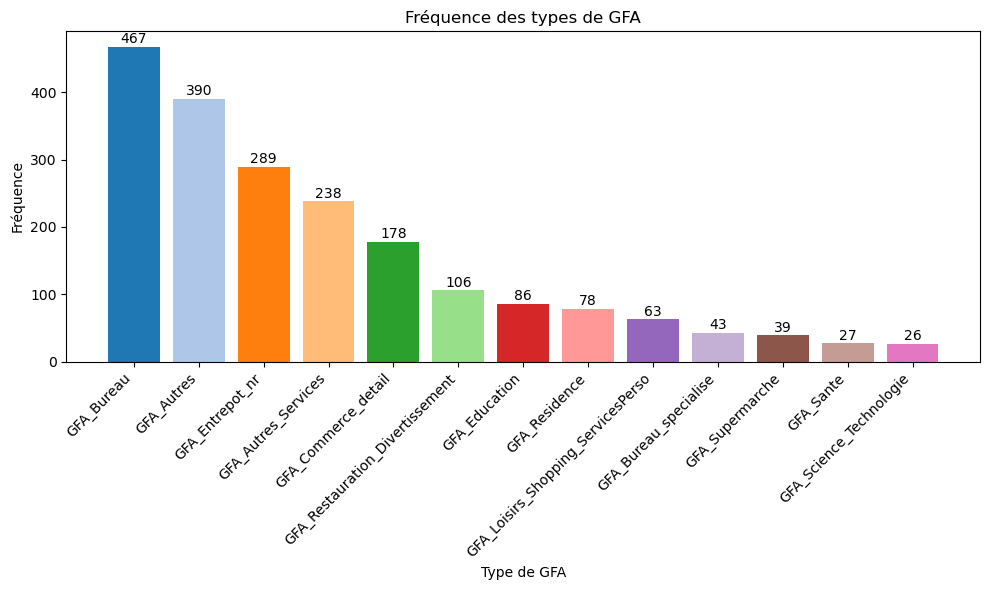

In [118]:
# Calculer la fréquence des valeurs non nulles pour chaque GFA
gfa_columns = [col for col in df.columns if col.startswith('GFA_')]
gfa_frequencies = {col: (df[col] > 0).sum() for col in gfa_columns}

# série décroissante
gfa_frequencies_series = pd.Series(gfa_frequencies).sort_values(ascending=False)

# Créer le bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(gfa_frequencies_series.index, gfa_frequencies_series.values, color=plt.cm.tab20(range(len(gfa_frequencies_series))))

# Ajouter le nombre en haut de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.title('Fréquence des types de GFA')
plt.xlabel('Type de GFA')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Passage au pourcentage**

In [119]:
df = df.rename(columns={'PropertyGFAParking': 'GFA_Parking'})
gfa_columns = [col for col in df.columns if col.startswith('GFA_')]

# Calcul du pourcentage d'utilisation pour chaque type d'utilisation'
for col in gfa_columns:
    new_col_name = col + '_pct'
    df[new_col_name] = (df[col] / df['PropertyGFATotal']) * 100

# Régulation pour que la somme des nouvelles colonnes ne dépasse pas 100
sum_values = df[[col + '_pct' for col in gfa_columns]].sum(axis=1)
mask = sum_values > 100
for col in [col + '_pct' for col in gfa_columns]:
    df.loc[mask, col] = df.loc[mask, col] * (100 / sum_values[mask])

# supprimer les colonnes des énergies en kBtu
df = df.drop(columns=gfa_columns).copy()

In [120]:
df.head(5)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
6             10      2016  NonResidential               Hotel   

              PropertyName          Address     City State  ZipCode  \
0     Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1          Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2  5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
6                   Camlin  1619 9th Avenue  Seattle    WA  98101.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
6                    0660000825                    7     DOWNTOWN  47.61390   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
6 -122.33283                1.0              11             83008   

   PropertyGFABuilding(s) LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                   88434              Residence                    88434.0   
1                   88502              Residence                    83880.0   
2                  759392              Residence                   756493.0   
3                   61320              Residence                    61320.0   
6                   83008              Residence                    81352.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1              Autres_Services                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
6                         None                              0.0   

   ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         None                             0.0   
1  Restauration_Divertissement                          4622.0   
2                       Autres                          2899.0   
3                         None                             0.0   
6                       Autres                          1656.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
6                      NaN             27.0         70.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           83.661424          176.100006            179.399994   
2           77.331177          241.899994            244.100006   
3          113.300003          216.199997            224.000000   
6           74.500000          146.600006            154.699997   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  Electricity(kWh)  \
0            7226362.5              7456910.0      1.156514e+06   
1            8387933.0              8664479.0      9.504252e+05   
2           7258702

## Résultats du nettoyage

In [121]:
df.head(5)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
6             10      2016  NonResidential               Hotel   

              PropertyName          Address     City State  ZipCode  \
0     Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1          Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2  5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
6                   Camlin  1619 9th Avenue  Seattle    WA  98101.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
6                    0660000825                    7     DOWNTOWN  47.61390   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
6 -122.33283                1.0              11             83008   

   PropertyGFABuilding(s) LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                   88434              Residence                    88434.0   
1                   88502              Residence                    83880.0   
2                  759392              Residence                   756493.0   
3                   61320              Residence                    61320.0   
6                   83008              Residence                    81352.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1              Autres_Services                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
6                         None                              0.0   

   ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         None                             0.0   
1  Restauration_Divertissement                          4622.0   
2                       Autres                          2899.0   
3                         None                             0.0   
6                       Autres                          1656.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
6                      NaN             27.0         70.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           83.661424          176.100006            179.399994   
2           77.331177          241.899994            244.100006   
3          113.300003          216.199997            224.000000   
6           74.500000          146.600006            154.699997   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  Electricity(kWh)  \
0            7226362.5              7456910.0      1.156514e+06   
1            8387933.0              8664479.0      9.504252e+05   
2           7258702

Maintenant que le traitement des valeurs abérrantes et manquante a été fait, on peut supprimer les colonnes qui ne nous servirons pas pour nos modèles.

In [122]:
cols_to_drop = ['OSEBuildingID', 'DataYear', 'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State',
                'ZipCode', 'CouncilDistrictCode', 'TaxParcelIdentificationNumber', 'YearsENERGYSTARCertified', 'Comments',
                'Latitude', 'Longitude', 'Electricity(kWh)', 'NaturalGas(therms)', 'Outlier', 
                'SiteEUI(kBtu/sf)', 'PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'FourthLargestPropertyUseType', 
                'FourthLargestPropertyUseTypeGFA']

df_selected = df.drop(columns=cols_to_drop).copy()

In [123]:
df_selected.shape

(1135, 29)

In [124]:
missing_values_count = df_selected.isnull().sum()
total_cells = np.product(df_selected.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 1.25 %


<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

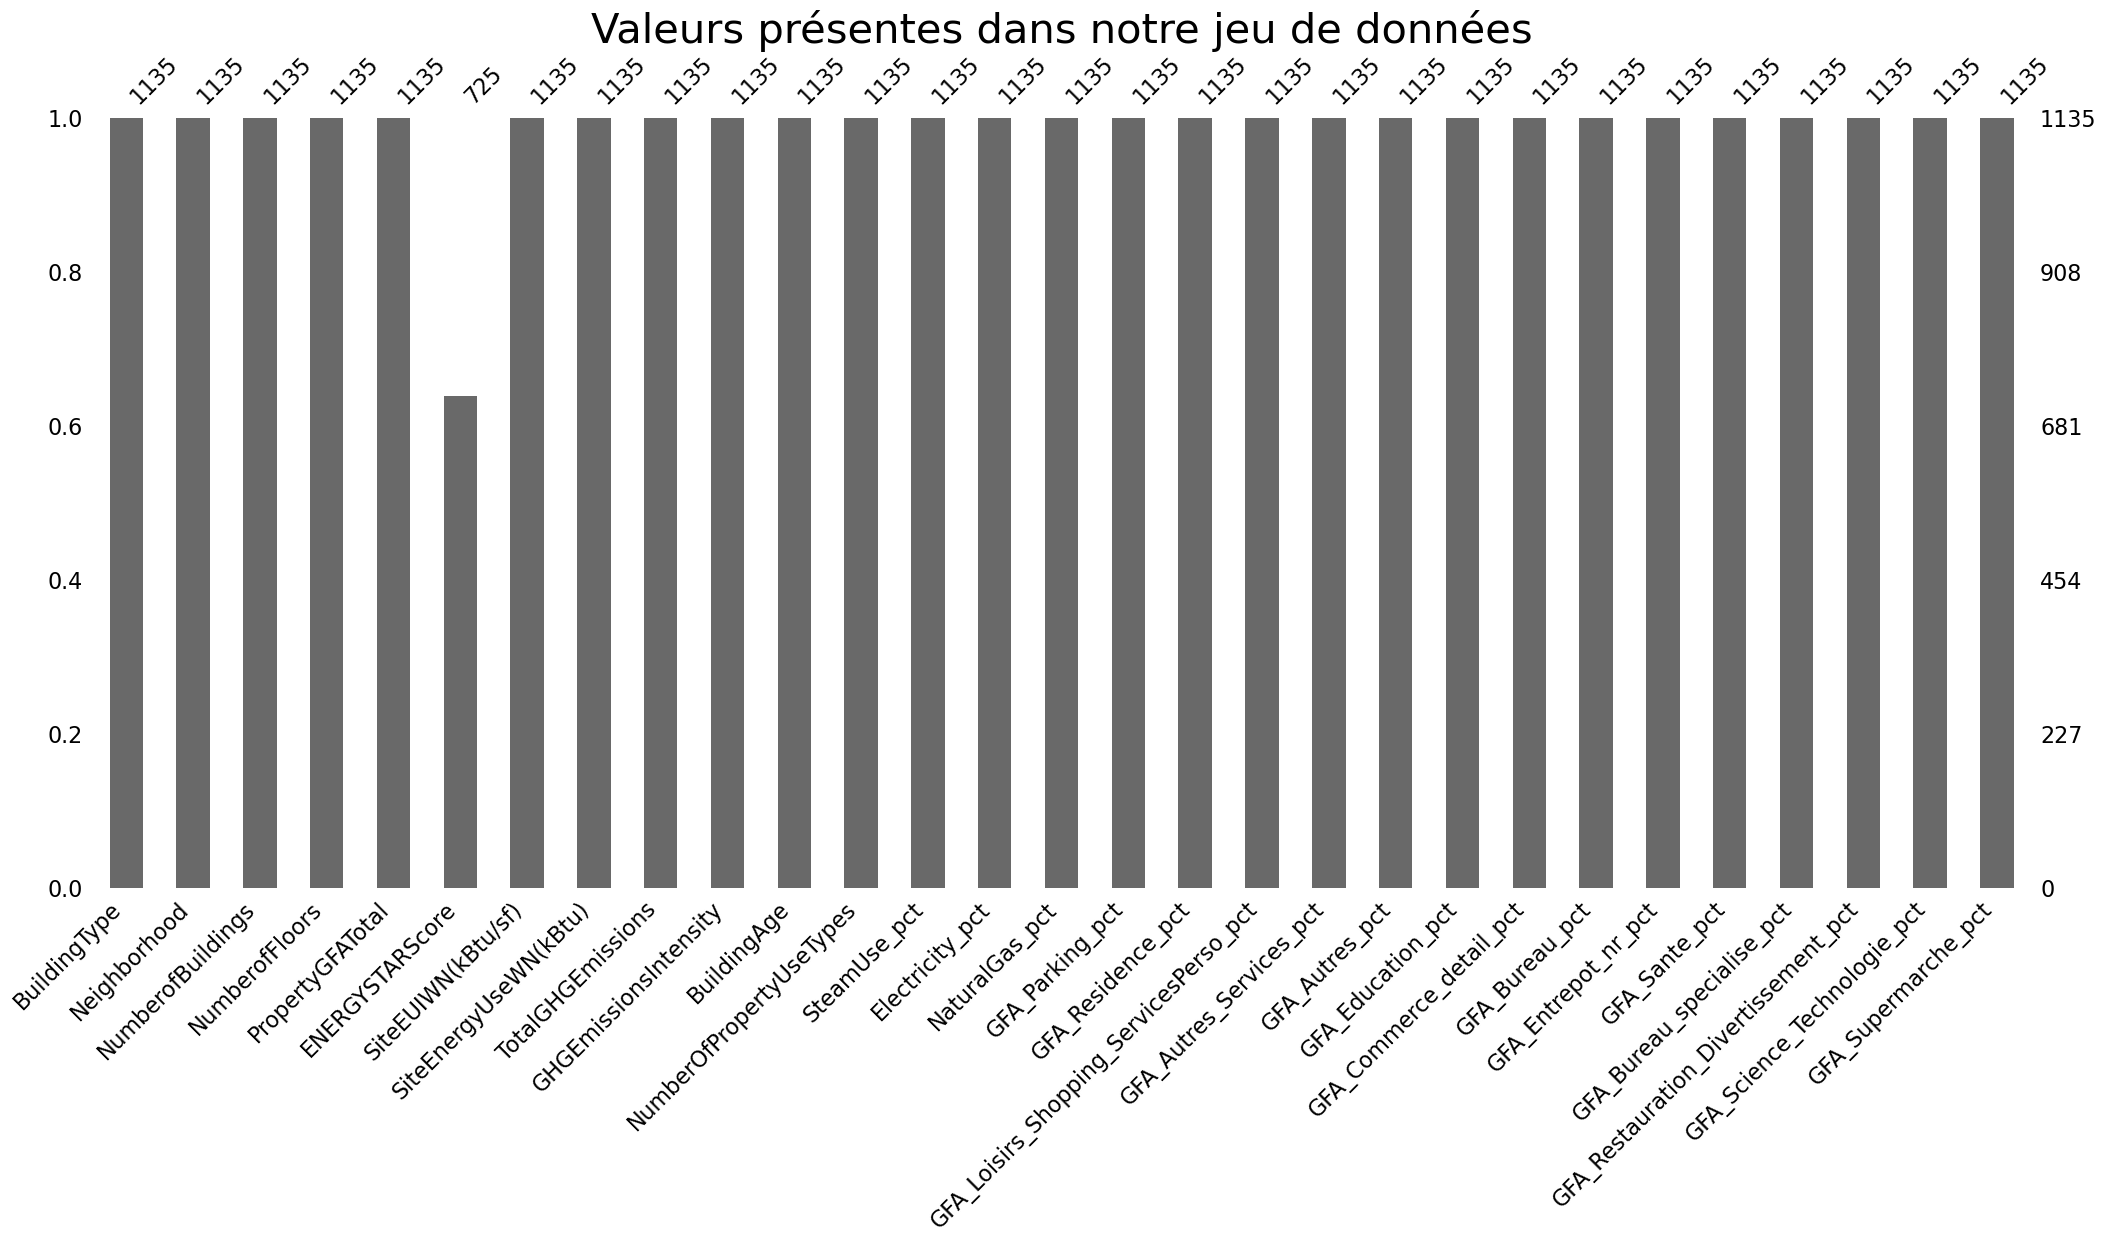

In [125]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(df_selected)

# Analyse Exploratoire des Données

## Analyse Univariée

### Variables numériques

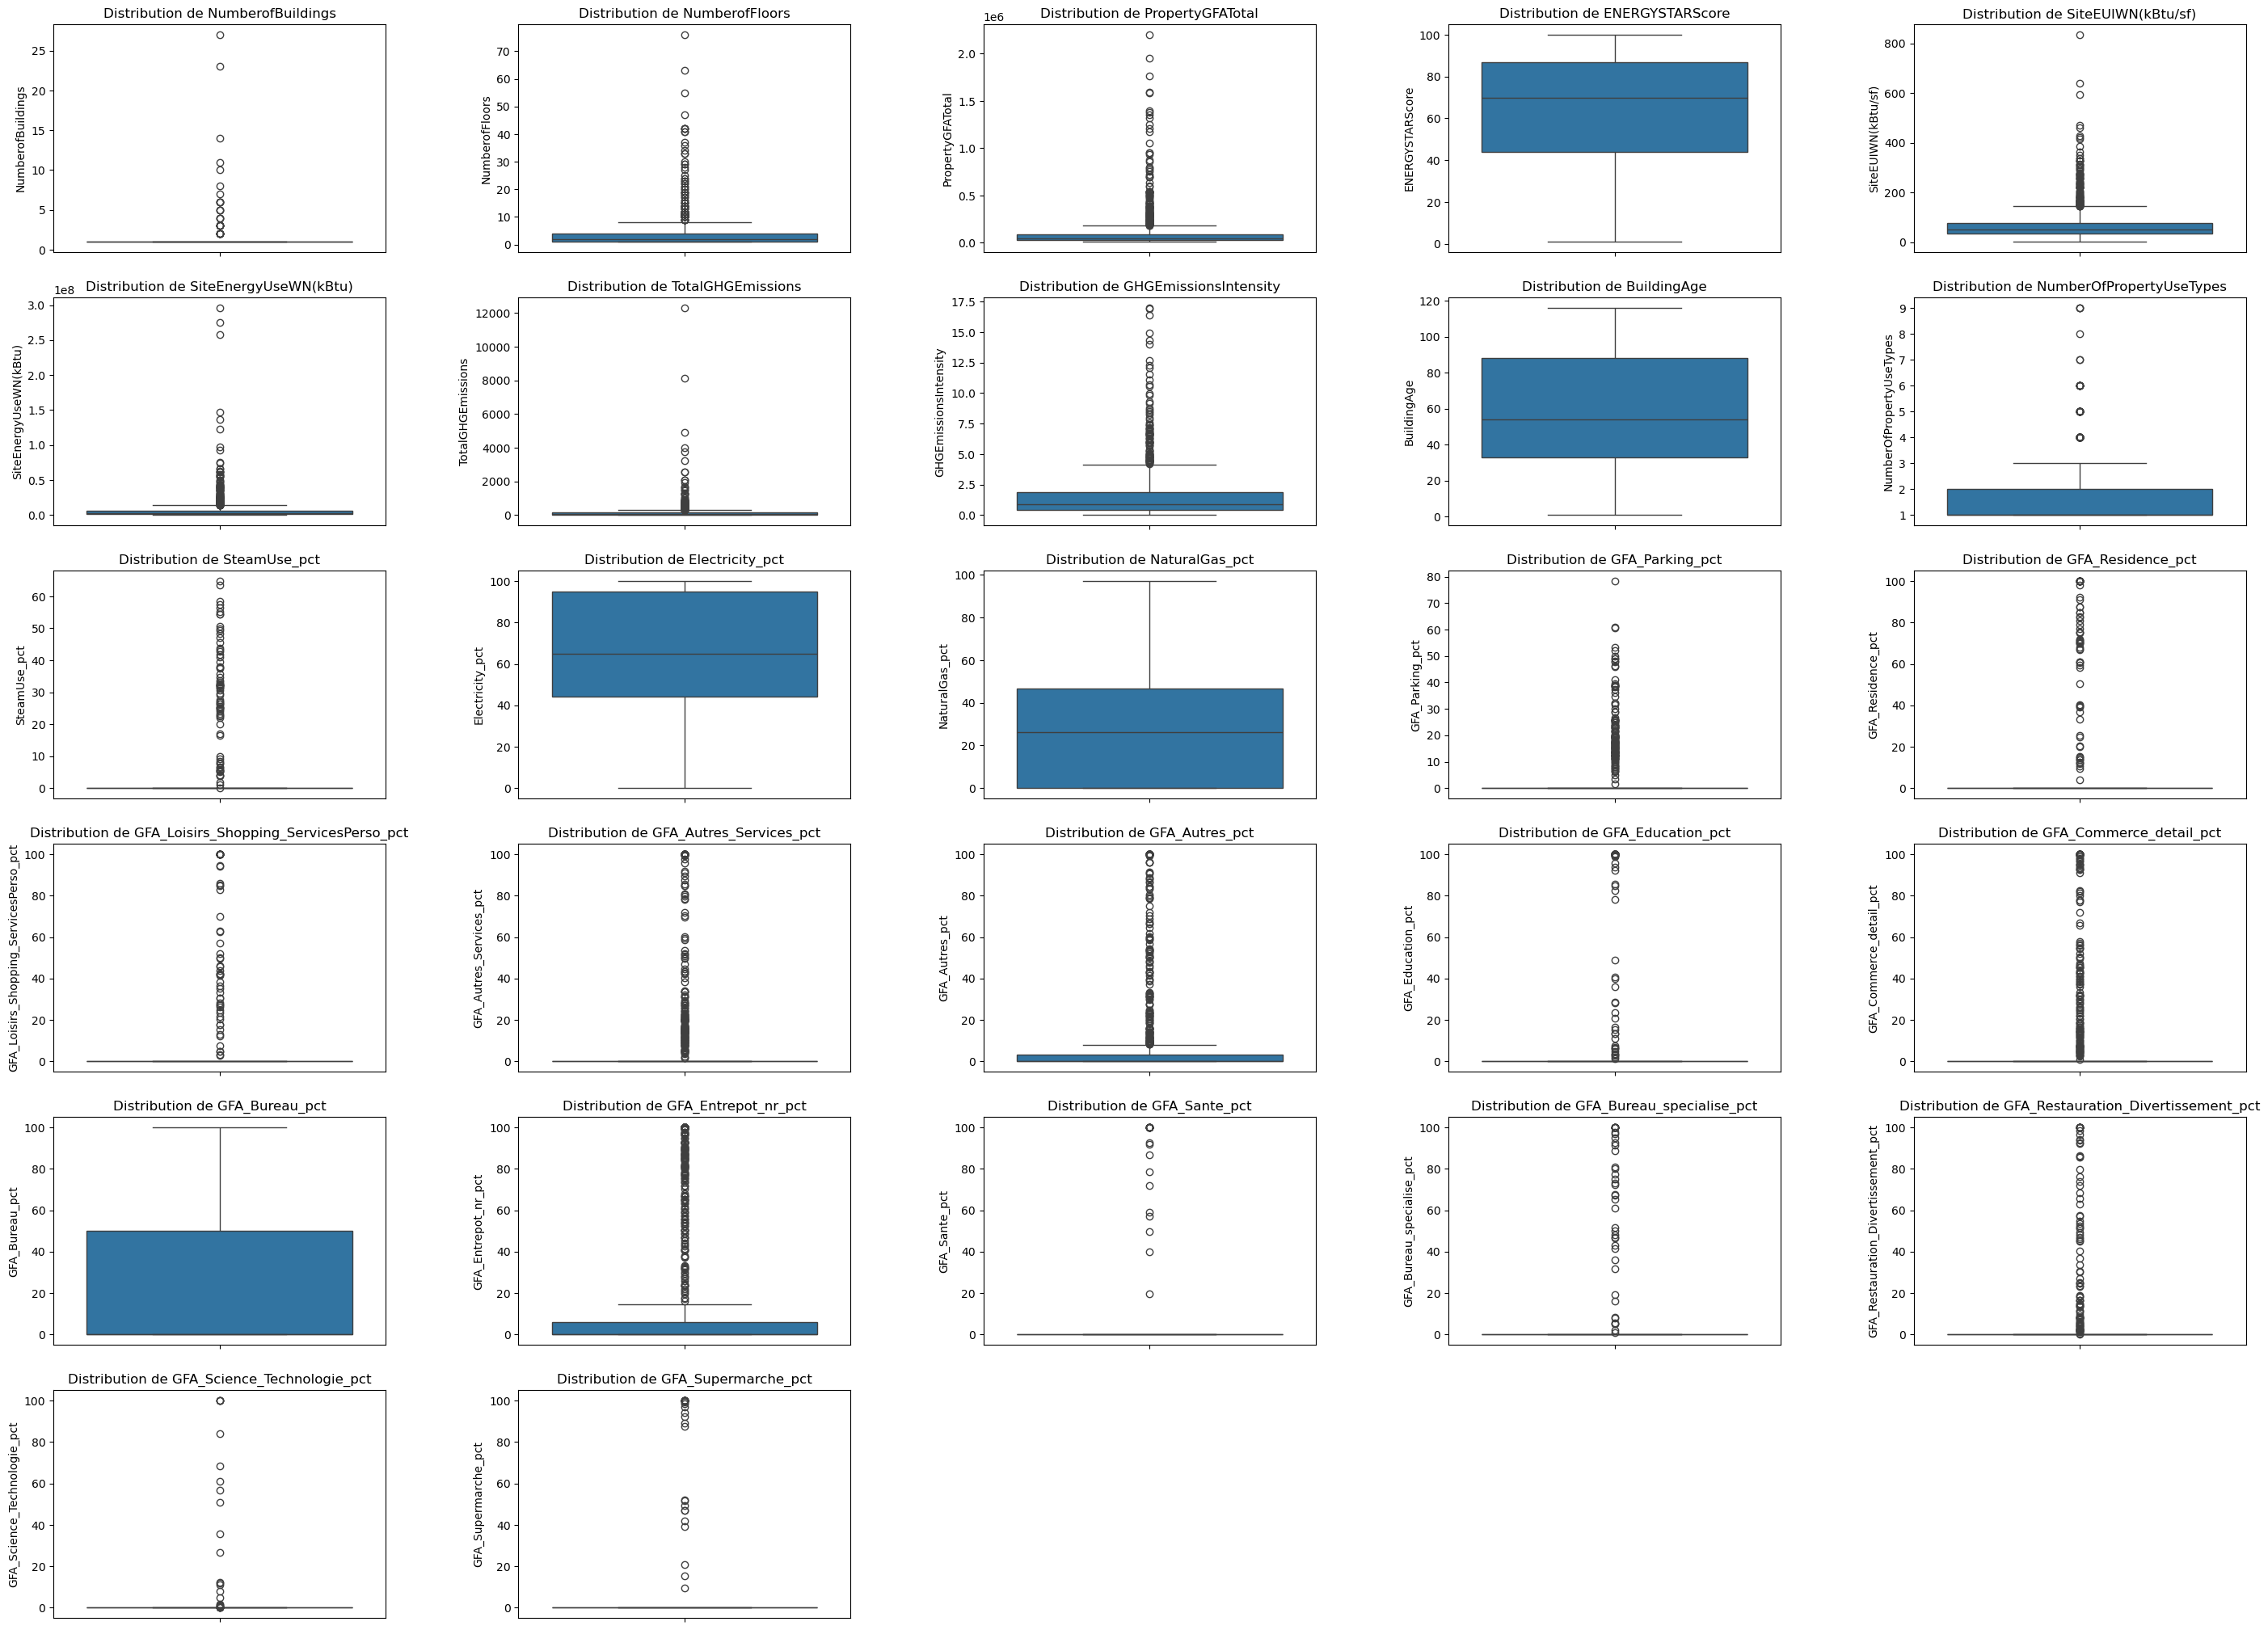

In [126]:
# Sélectionner uniquement les colonnes numériques
numerics_col = df_selected.select_dtypes(include=['number'])

# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(35,30))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.4)

for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.boxplot(y=df_selected[column], ax=ax)
    ax.set_title(f'Distribution de {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 35):
    fig.delaxes(axes.flatten()[j])

plt.show()

In [127]:
df_selected.describe()

NumberofBuildings  NumberofFloors  PropertyGFATotal  ENERGYSTARScore  \
count        1135.000000     1135.000000      1.135000e+03       725.000000   
mean            1.138326        3.954185      1.041771e+05        63.257931   
std             1.254720        6.194782      1.957131e+05        28.022159   
min             1.000000        1.000000      1.128500e+04         1.000000   
25%             1.000000        1.000000      2.774000e+04        44.000000   
50%             1.000000        2.000000      4.447600e+04        70.000000   
75%             1.000000        4.000000      8.977500e+04        87.000000   
max            27.000000       76.000000      2.200000e+06       100.000000   

       SiteEUIWN(kBtu/sf)  SiteEnergyUseWN(kBtu)  TotalGHGEmissions  \
count         1135.000000           1.135000e+03        1135.000000   
mean            69.090064           7.195675e+06         155.616855   
std             69.269370           1.859154e+07         545.543551   
min              1.500000           5.811420e+04           0.400000   
25%             33.650000           1.220033e+06          19.210000   
50%             50.500000           2.472120e+06          46.490000   
75%             77.699997           6.362965e+06         127.850000   
max            834.400024           2.959299e+08       12307.160000   

       GHGEmissionsIntensity  BuildingAge  NumberOfPropertyUseTypes  \
count            1135.000000  1135.000000               1135.000000   
mean                1.574564    57.340088                  1.854626   
std                 2.054811    32.096206                  1.176269   
min                 0.010000     1.000000                  1.000000   
25%                 0.390000    33.000000                  1.000000   
50%                 0.900000    54.000000                  1.000000   
75%                 1.900000    88.000000                  2.000000   
max                16.990000   116.000000                  9.000000   

       SteamUse_pct  Electricity_pct  NaturalGas_pct  GFA_Parking_pct  \
count   1135.000000      1135.000000     1135.000000      1135.000000   
mean       1.876148        66.117254       26.782610         2.751575   
std        8.330666        26.852495       23.814148         8.499669   
min        0.000000         0.000000        0.000000         0.000000   
25%        0.000000        44.369063        0.000000         0.000000   
50%        0.000000        64.986506       26.072621         0.000000   
75%        0.000000        94.885099       46.638617         0.000000   
max       64.773098       100.000000       97.077764        78.377781   

       GFA_Residence_pct  GFA_Loisirs_Shopping_ServicesPerso_pct  \
count        1135.000000                             1135.000000   
mean            4.717107                                3.205735   
std            19.290353                               15.576466   
min             0.000000                                0.000000   
25%             0.000000                                0.000000   
50%             0.000000                                0.000000   
75%             0.000000                                0.000000   
max           100.000000                              100.000000   

       GFA_Autres_Services_pct  GFA_Autres_pct  GFA_Education_pct  \
count              1135.000000     1135.000000        1135.000000   
mean                  9.279812       10.157794           5.806918   
std                  24.975130       25.430441          22.729723   
min                   0.000000        0.000000           0.000000   
25%                   0.000000        0.000000           0.000000   
50%                   0.000000        0.000000           0.000000   
75%                   0.000000        3.229034           0.000000   
max                 100.000000      100.000000         100.000000   

       GFA_Commerce_detail_pct  GFA_Bureau_pct  GFA_Entrepot_nr_pct  \
count              1135.000000     1135.000000     

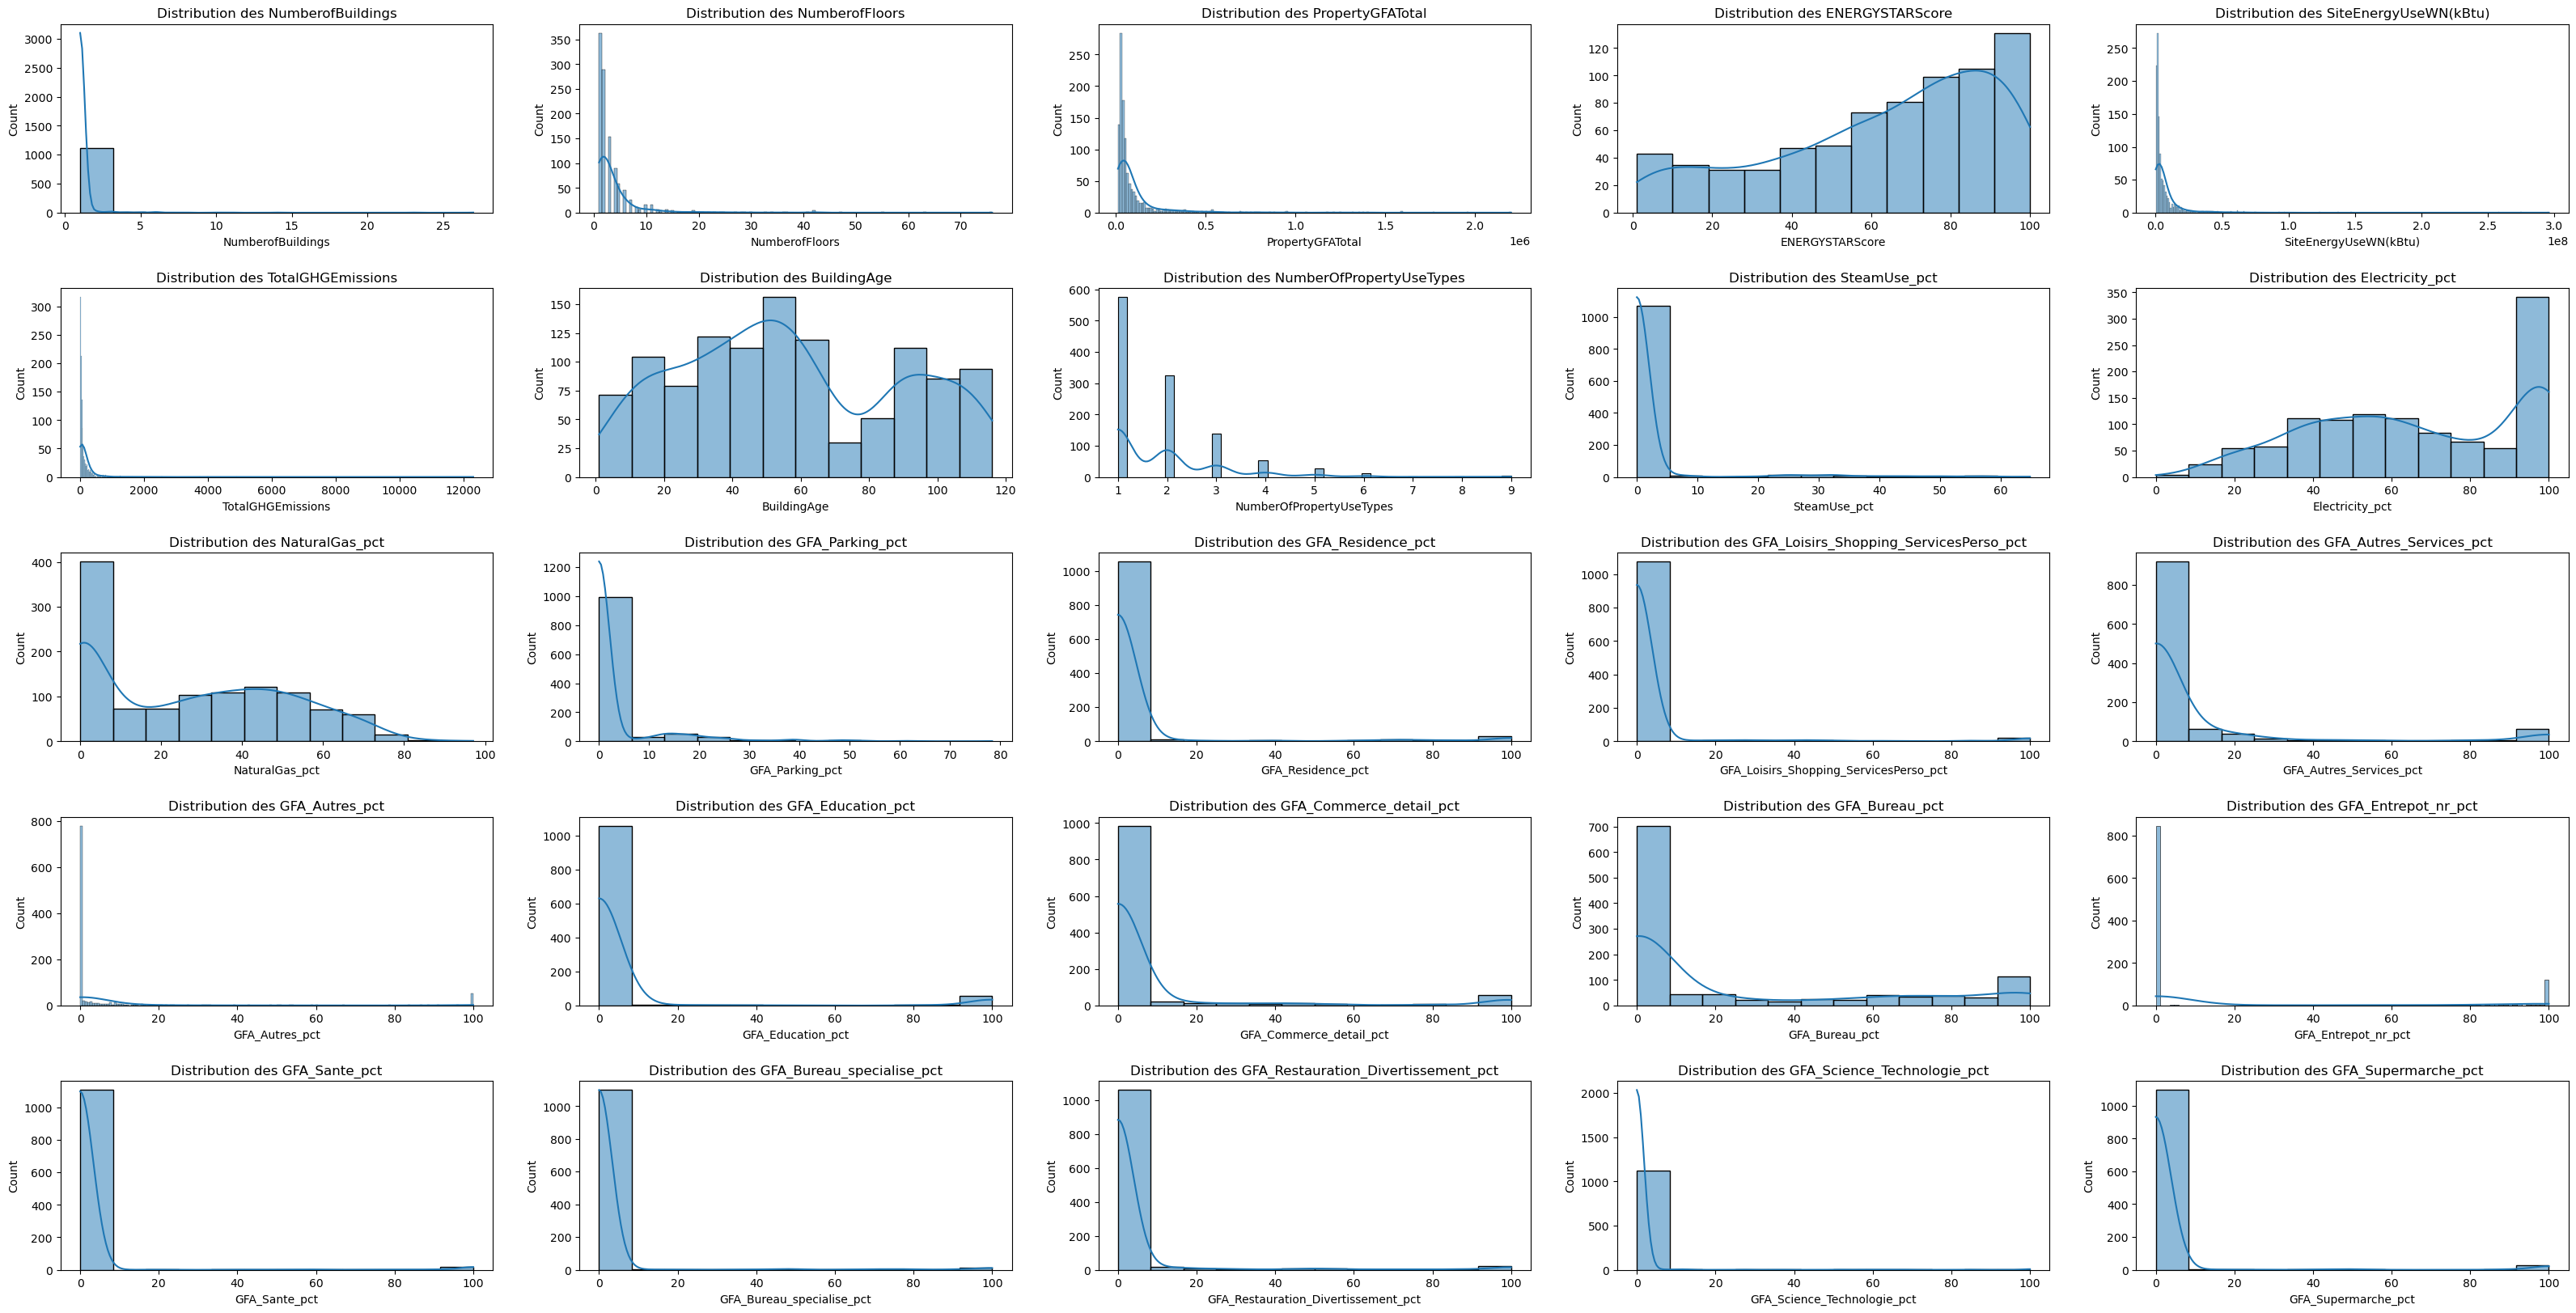

In [128]:
numerics_col_selected = [col for col in numerics_col if col not in ['SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity']]

# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(40,20))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.4)

# Density plot
for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col_selected)):
    sns.histplot(data=df_selected, x=column, kde=True, ax=ax)
    ax.set_title(f'Distribution des {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 25):
    fig.delaxes(axes.flatten()[j])

plt.show()

In [129]:
# Compter le nombre de valeurs zéro ou négatives dans 'TotalGHGEmissions'
count_zero_neg_ghg = len(df_selected[df_selected['TotalGHGEmissions'] <= 0])

# Compter le nombre de valeurs zéro ou négatives dans 'SiteEnergyUse(kBtu)'
count_zero_neg_energy = len(df_selected[df_selected['SiteEnergyUseWN(kBtu)'] <= 0])

# Afficher les résultats
print(f"Nombre de valeurs zéro ou négatives pour 'TotalGHGEmissions': {count_zero_neg_ghg}")
print(f"Nombre de valeurs zéro ou négatives pour 'SiteEnergyUseWN(kBtu)': {count_zero_neg_energy}")

Nombre de valeurs zéro ou négatives pour 'TotalGHGEmissions': 0
Nombre de valeurs zéro ou négatives pour 'SiteEnergyUseWN(kBtu)': 0


In [130]:
# Calculer le logarithme des colonnes 'TotalGHGEmissions' et 'SiteEnergyUseWN(kBtu)'
df_selected = df_selected.copy()
df_selected['Log_TotalGHGEmissions'] = np.log(df_selected['TotalGHGEmissions'])
df_selected['Log_SiteEnergyUseWN'] = np.log(df_selected['SiteEnergyUseWN(kBtu)'])

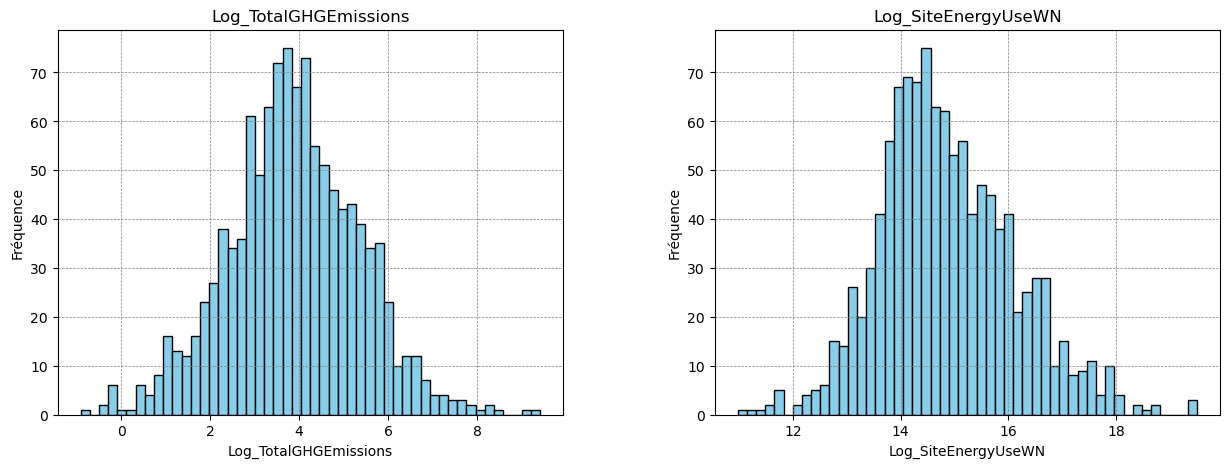

In [131]:
# Créez un histogramme pour TotalGHGEmissions et SiteEnergyUse(kBtu)
# Sélection des colonnes spécifiques
selected_columns = df_selected[['Log_TotalGHGEmissions','Log_SiteEnergyUseWN']]

# Créez un histogramme pour chaque variable numérique sélectionnée
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, column in zip(axes, selected_columns.columns):
    ax.hist(df_selected[column], bins=50, edgecolor='black', color='skyblue')
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Fréquence')
    # Ajouter un quadrillage
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
    
# Ajustez l'espace entre les subplots
plt.subplots_adjust(wspace=0.3)

# Affichez les histogrammes
plt.show()

### Variables catégorielles

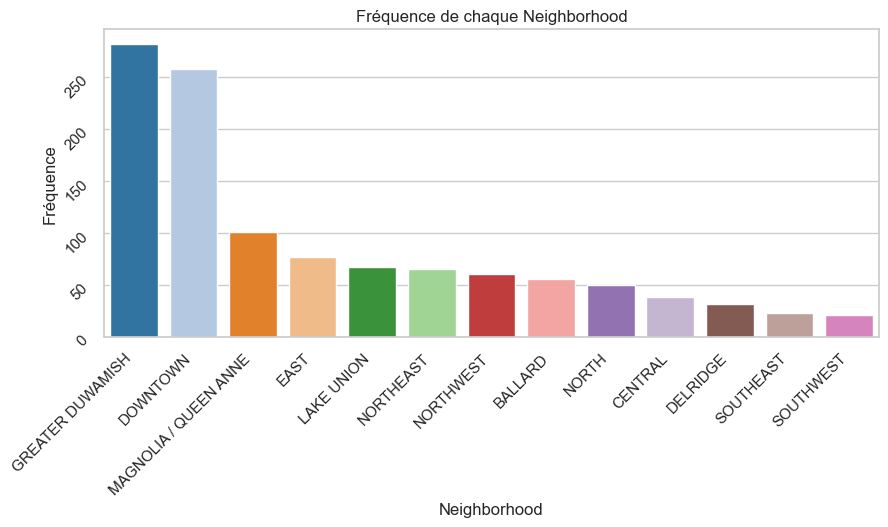

In [132]:
# Compter le nombre d'occurrences pour chaque Neighborhood
group_counts = df_selected['Neighborhood'].value_counts().reset_index()
group_counts.columns = ['Neighborhood', 'Counts']

plt.figure(figsize=(10, 4))
sns.set(style="whitegrid")

# Créer un graphique à barres
sns.barplot(x='Neighborhood', y='Counts', data=group_counts, hue='Neighborhood', palette="tab20", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque Neighborhood')
plt.ylabel('Fréquence')
plt.xlabel('Neighborhood')
plt.xticks(rotation=45, ha="right")

plt.show()

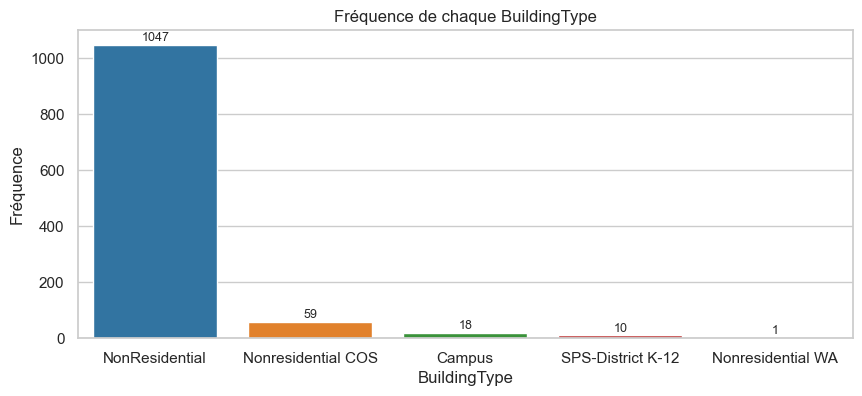

In [133]:
# Compter le nombre d'occurrences pour chaque BuildingType
group_counts = df_selected['BuildingType'].value_counts().reset_index()
group_counts.columns = ['BuildingType', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
barplot = sns.barplot(x='BuildingType', y='Counts', data=group_counts, hue='BuildingType', palette="tab10", legend=False)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque BuildingType')
plt.ylabel('Fréquence')
plt.xlabel('BuildingType')

# Itérer sur les barres pour afficher le nombre d'occurrences
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     size=9, xytext = (0, 5), 
                     textcoords = 'offset points')

plt.show()

La distribution des catégories est largement  déséquilibrée cce qui peut influencer la performance de nos modèles de ML, car les modèles pourraient être biaisés en faveur de la classe majoritaire. Il vaut mieux ne pas la considérer dans nos modèles et la supprimer.

In [134]:
df_selected = df_selected.drop(columns=['BuildingType'])

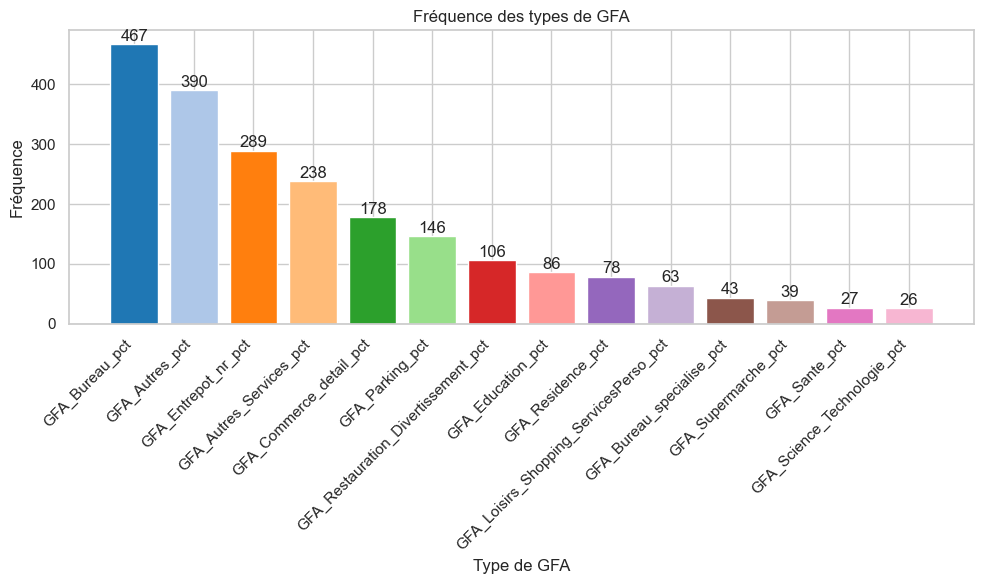

In [135]:
# Calculer la fréquence des valeurs non nulles pour chaque GFA
gfa_columns = [col for col in df_selected.columns if col.startswith('GFA_')]
gfa_frequencies = {col: (df_selected[col] > 0).sum() for col in gfa_columns}

# série décroissante
gfa_frequencies_series = pd.Series(gfa_frequencies).sort_values(ascending=False)

# Créer le bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(gfa_frequencies_series.index, gfa_frequencies_series.values, color=plt.cm.tab20(range(len(gfa_frequencies_series))))

# Ajouter le nombre en haut de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.title('Fréquence des types de GFA')
plt.xlabel('Type de GFA')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [136]:
gfa_frequencies_series

GFA_Bureau_pct                            467
GFA_Autres_pct                            390
GFA_Entrepot_nr_pct                       289
GFA_Autres_Services_pct                   238
GFA_Commerce_detail_pct                   178
GFA_Parking_pct                           146
GFA_Restauration_Divertissement_pct       106
GFA_Education_pct                          86
GFA_Residence_pct                          78
GFA_Loisirs_Shopping_ServicesPerso_pct     63
GFA_Bureau_specialise_pct                  43
GFA_Supermarche_pct                        39
GFA_Sante_pct                              27
GFA_Science_Technologie_pct                26
dtype: int64

## Analyse Bivariée

### Variables numériques

In [137]:
# Normalisation des données
scaler = StandardScaler()

df_normalized = df_selected.copy()

# Sélectionner uniquement les colonnes numériques
numerics_col = df_selected.select_dtypes(include=['number']).columns

# Appliquez la normalisation min-max aux données
df_normalized[numerics_col] = scaler.fit_transform(df_selected[numerics_col])

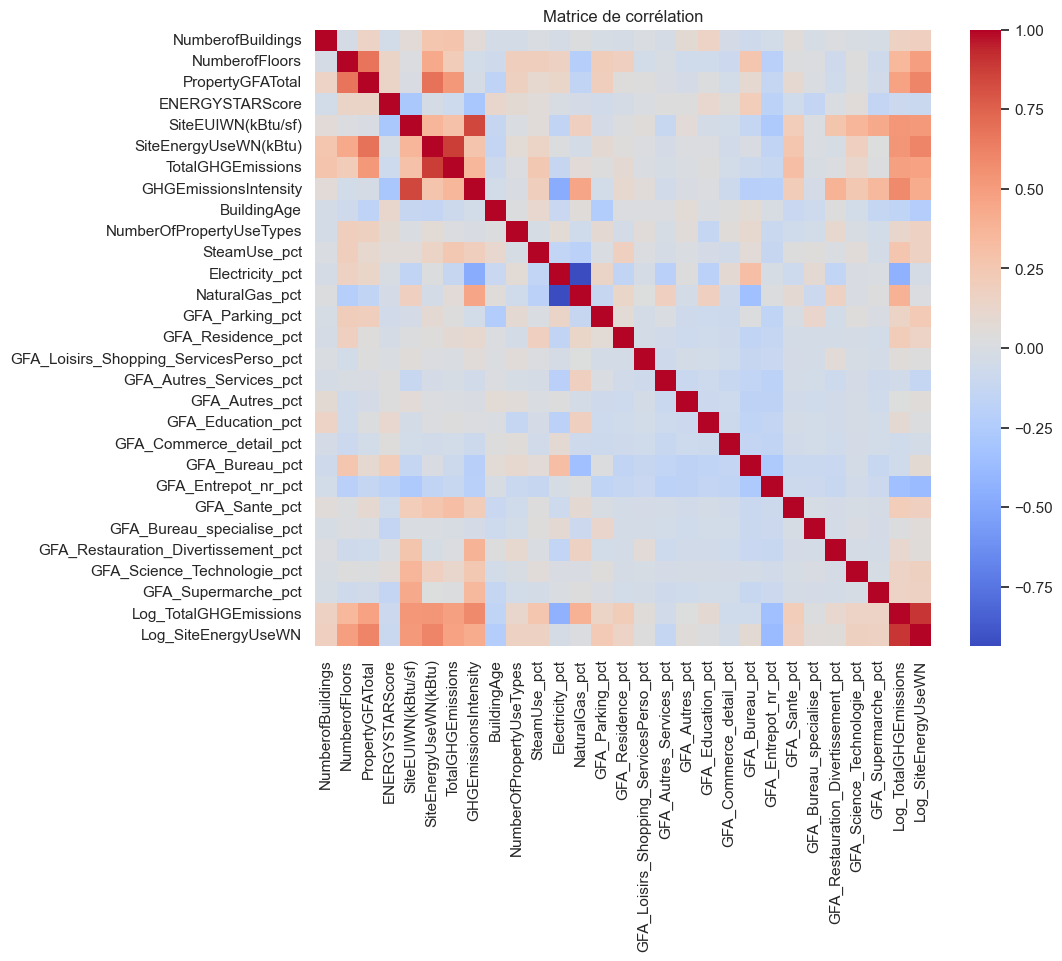

In [138]:
# Calcul de la matrice de corrélation
corr_matrix = df_normalized[numerics_col].corr()

# Création d'une heatmap avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Titre et affichage du graphique
plt.title('Matrice de corrélation')
plt.show()

### Variables catégorielles

In [139]:
def plot_boxplots_by_category(df, category):
    sns.set(style="whitegrid")
    

    # Lignes en fonction du nombre de catégories
    num_categories = len(df[category].unique())
    height_per_subplot = 3
    total_height = (num_categories * height_per_subplot) / 10

    # 2 colonnes : SiteEnergyUseWN(kBtu) et TotalGHGEmissions
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, total_height), constrained_layout=True)
    axes = axes.flatten()

    # Orderby median de SiteEnergyUseWN(kBtu)
    order_energy = df.groupby(category)['SiteEUIWN(kBtu/sf)'].median().sort_values(ascending=False).index
    # SiteEnergyUseWN(kBtu) boxplot
    sns.boxplot(y=category, x='SiteEUIWN(kBtu/sf)', data=df, orient='h', ax=axes[0], order=order_energy, hue=category, palette="tab20")
    axes[0].set_title(f'SiteEUIWN(kBtu/sf) by {category}')
    axes[0].set_xlabel('SiteEUIWN(kBtu/sf)')
    axes[0].set_ylabel(category)

    # Orderby median de  TotalGHGEmissions
    order_ghg = df.groupby(category)['GHGEmissionsIntensity'].median().sort_values(ascending=False).index
    # TotalGHGEmissions boxplot
    sns.boxplot(y=category, x='GHGEmissionsIntensity', data=df, orient='h', ax=axes[1], order=order_ghg, hue=category, palette="tab20")
    axes[1].set_title(f'GHGEmissionsIntensity by {category}')
    axes[1].set_xlabel('GHGEmissionsIntensity')
    axes[1].set_ylabel('')

    #plt.tight_layout()
    plt.show()

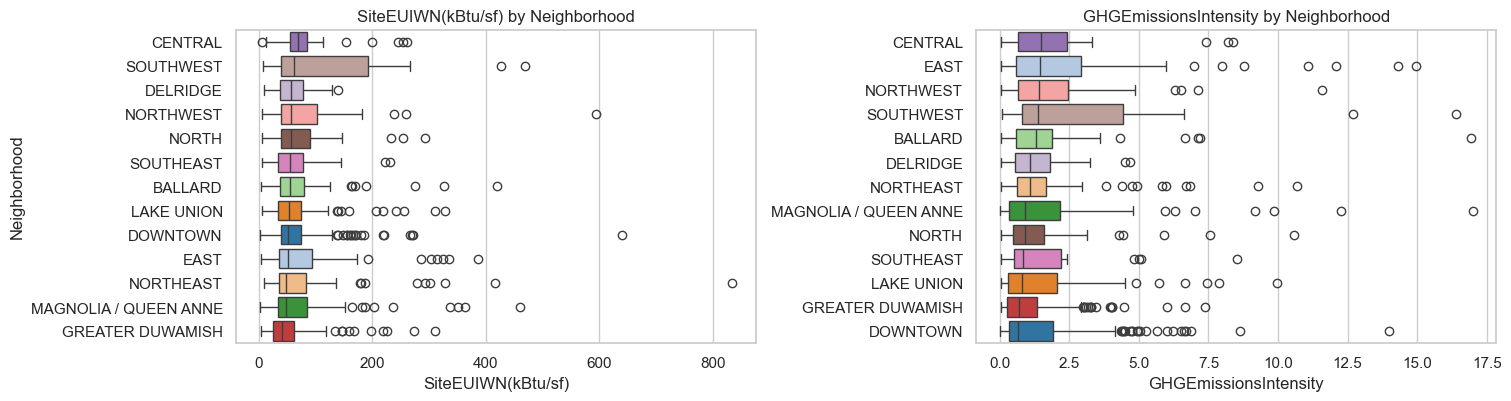

In [140]:
categorical_columns = ['Neighborhood']
for category in categorical_columns:
    plot_boxplots_by_category(df_selected, category)

## Analyse Multivariée (ANOVA)

In [141]:
def perform_anova_tukey(df, numeric_var, categorical_var):
    # Effectuez l'ANOVA
    formula = f"{numeric_var} ~ C({categorical_var})"
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Effectuez le test de Tukey pour les comparaisons post-hoc
    tukey_result = pairwise_tukeyhsd(endog=df[numeric_var], groups=df[categorical_var], alpha=0.05)
    
    # Affichez les résultats
    print(f"ANOVA Table for {numeric_var} by {categorical_var}:")
    print(anova_table)
    print("\n")
    print(f"\nTukey's HSD Results for {numeric_var} by {categorical_var}:")
    print(tukey_result)

In [142]:
# Renommer la colonne pour ne pas avoir de probleme avec les caracteres spéciaux
df_selected.rename(columns={'SiteEUIWN(kBtu/sf)': 'SiteEUIWN_kBtu_sf'}, inplace=True)

### Neighborhood

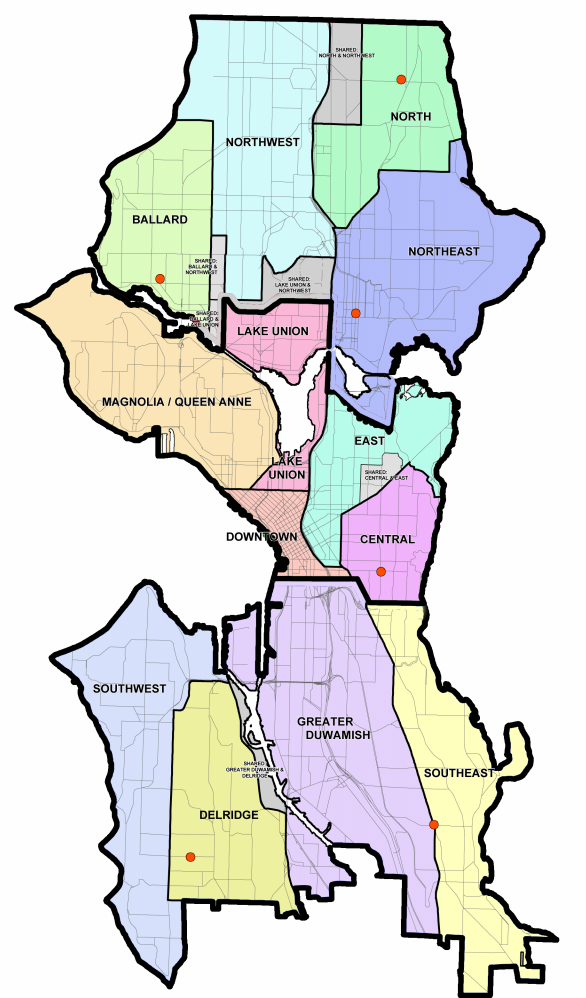

In [143]:
# Afficher les quartiers de Seattle
Image(filename="Map_of_Seattle,_divided_by_districts.png", width=400, height=150)

In [144]:
perform_anova_tukey(df_selected, 'SiteEUIWN_kBtu_sf', 'Neighborhood')

ANOVA Table for SiteEUIWN_kBtu_sf by Neighborhood:
                       sum_sq      df         F    PR(>F)
C(Neighborhood)  2.357189e+05    12.0  4.233935  0.000001
Residual         5.205492e+06  1122.0       NaN       NaN



Tukey's HSD Results for SiteEUIWN_kBtu_sf by Neighborhood:
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                group2        meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------
              BALLARD               CENTRAL    8.621    1.0 -38.5421  55.7841  False
              BALLARD              DELRIDGE  -15.077 0.9988 -65.1887  35.0347  False
              BALLARD              DOWNTOWN -10.2057 0.9985 -43.5428  23.1314  False
              BALLARD                  EAST   6.3545    1.0 -33.3604  46.0693  False
              BALLARD      GREATER DUWAMISH -25.0517 0.3661 -58.1348   8.0315  False
              BALLARD            

In [145]:
# Test avec un regroupement de catégories
def map_areas_neighborhood(neighborhood): 
    # Zones urbaines
    urban_core = ['NORTHWEST', 'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'CENTRAL', 'NORTH', 'LAKE UNION', 'EAST', 'NORTHEAST']
    
    # Zones commerces et industrielles
    commercial_industrial = ['DOWNTOWN', 'GREATER DUWAMISH', 'DELRIDGE', 'SOUTHEAST', 'SOUTHWEST']

    if neighborhood in urban_core:
        return 'urban_core'
    else:
        return 'commercial_industrial'

df_selected['GroupedNeighborhood'] = df_selected['Neighborhood'].apply(map_areas_neighborhood)


In [146]:
perform_anova_tukey(df_selected, 'SiteEUIWN_kBtu_sf', 'GroupedNeighborhood')

ANOVA Table for SiteEUIWN_kBtu_sf by GroupedNeighborhood:
                              sum_sq      df          F    PR(>F)
C(GroupedNeighborhood)  9.914078e+04     1.0  21.026776  0.000005
Residual                5.342070e+06  1133.0        NaN       NaN



Tukey's HSD Results for SiteEUIWN_kBtu_sf by GroupedNeighborhood:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
        group1          group2   meandiff p-adj lower   upper  reject
---------------------------------------------------------------------
commercial_industrial urban_core  18.7636   0.0 10.735 26.7923   True
---------------------------------------------------------------------


In [147]:
perform_anova_tukey(df_selected, 'GHGEmissionsIntensity', 'GroupedNeighborhood')

ANOVA Table for GHGEmissionsIntensity by GroupedNeighborhood:
                             sum_sq      df          F    PR(>F)
C(GroupedNeighborhood)    98.360976     1.0  23.763507  0.000001
Residual                4689.669183  1133.0        NaN       NaN



Tukey's HSD Results for GHGEmissionsIntensity by GroupedNeighborhood:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
        group1          group2   meandiff p-adj lower  upper  reject
--------------------------------------------------------------------
commercial_industrial urban_core    0.591   0.0 0.3531 0.8289   True
--------------------------------------------------------------------


In [148]:
df_selected.drop(columns=['Neighborhood'], inplace=True)

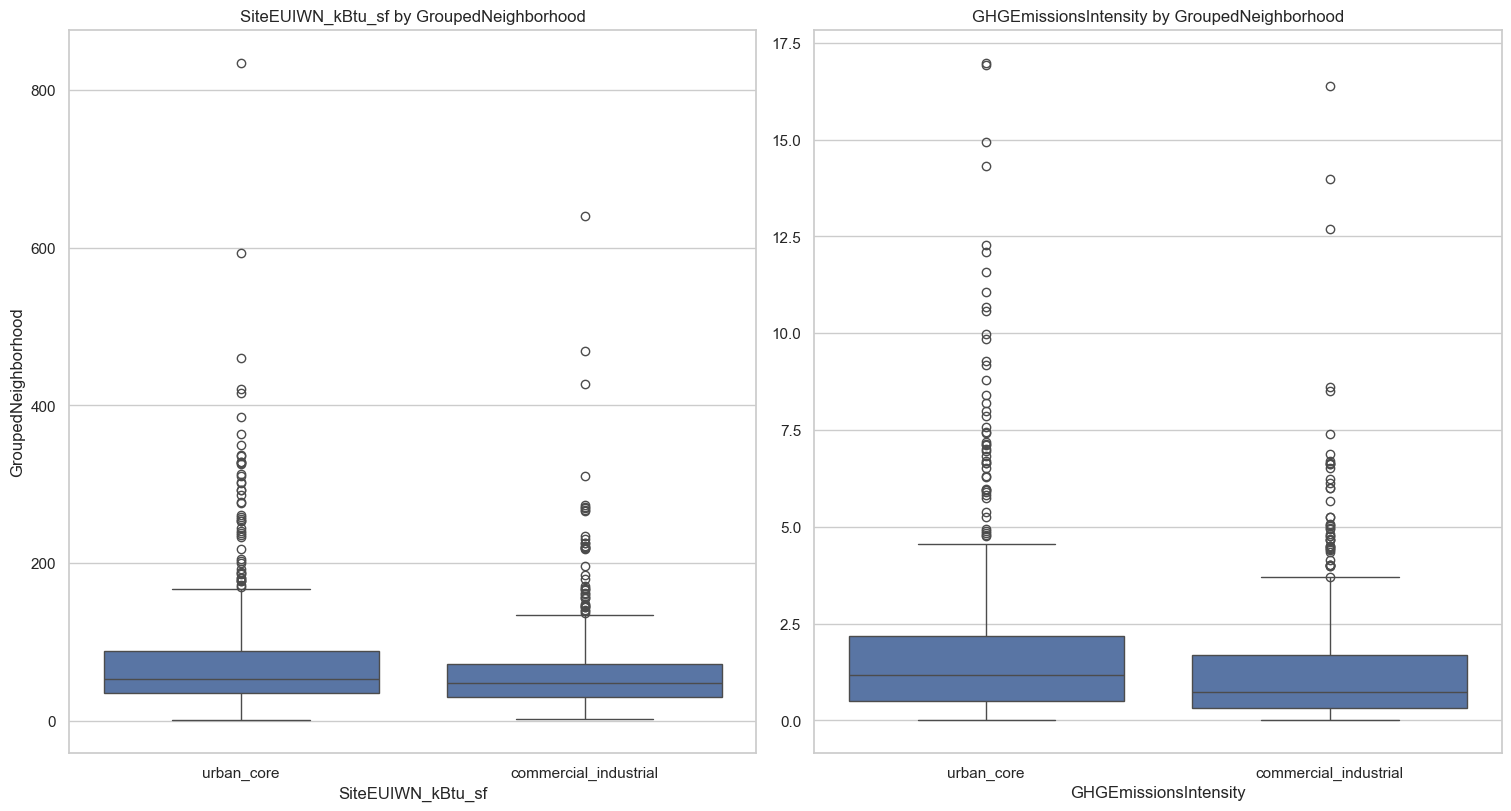

In [149]:
# 2 colonnes : SiteEnergyUseWN(kBtu) et TotalGHGEmissions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), constrained_layout=True)
sns.set(style="whitegrid")

# Orderby median de SiteEnergyUseWN(kBtu)
order_energy = df_selected.groupby('GroupedNeighborhood')['SiteEUIWN_kBtu_sf'].median().sort_values(ascending=False).index
# SiteEnergyUseWN(kBtu) boxplot
sns.boxplot(y='SiteEUIWN_kBtu_sf', x='GroupedNeighborhood', data=df_selected, ax=axes[0], order=order_energy)
axes[0].set_title(f'SiteEUIWN_kBtu_sf by GroupedNeighborhood')
axes[0].set_xlabel('SiteEUIWN_kBtu_sf')
axes[0].set_ylabel('GroupedNeighborhood')

# Orderby median de  TotalGHGEmissions
order_ghg = df_selected.groupby('GroupedNeighborhood')['GHGEmissionsIntensity'].median().sort_values(ascending=False).index
# TotalGHGEmissions boxplot
sns.boxplot(y='GHGEmissionsIntensity', x='GroupedNeighborhood', data=df_selected, ax=axes[1], order=order_ghg)
axes[1].set_title(f'GHGEmissionsIntensity by GroupedNeighborhood')
axes[1].set_xlabel('GHGEmissionsIntensity')
axes[1].set_ylabel('')

#plt.tight_layout()
plt.show()

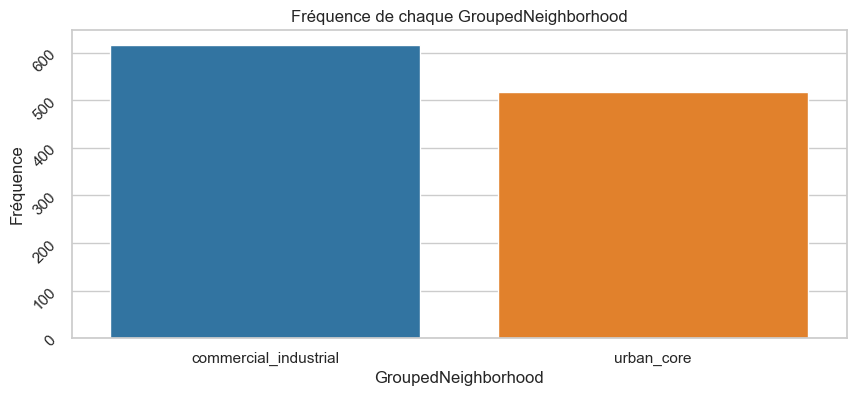

In [150]:
# Compter le nombre d'occurrences pour chaque GroupedNeighborhood
group_counts = df_selected['GroupedNeighborhood'].value_counts().reset_index()
group_counts.columns = ['GroupedNeighborhood', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='GroupedNeighborhood', y='Counts', data=group_counts, hue='GroupedNeighborhood', palette="tab10", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque GroupedNeighborhood')
plt.ylabel('Fréquence')
plt.xlabel('GroupedNeighborhood')

plt.show()

In [151]:
# Créez un tableau croisé des deux variables
cross_table = pd.crosstab(df_selected['GroupedNeighborhood'], df_selected['SiteEUIWN_kBtu_sf'])

# Effectuez le test du chi-carré
chi2, p, _, _ = chi2_contingency(cross_table)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

Chi-squared value: 935.6163943522128
P-value: 0.43305896577369646


Les différences semblent plus provenir du type de bâtiment dans ces quartiers que vraiment des quartiers en eux-même. Il faudra peut etre retirer cette variable pour créer nos modèles. (à tester)

# Export des données

In [152]:
# Suppression des dernières fuites de données
df_selected.drop(columns=['SiteEUIWN_kBtu_sf','GHGEmissionsIntensity', 'GroupedNeighborhood'], inplace=True)

In [153]:
df_selected.shape

(1135, 27)

In [154]:
path     = "data/cleaned/"
filename = "df_cleaned.csv"

In [155]:
df_selected.to_csv(path+filename, index=False)

In [156]:
df_selected.head(5)

NumberofBuildings  NumberofFloors  PropertyGFATotal  ENERGYSTARScore  \
0                1.0              12             88434             60.0   
1                1.0              11            103566             61.0   
2                1.0              41            956110             43.0   
3                1.0              10             61320             56.0   
6                1.0              11             83008             27.0   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  BuildingAge  \
0              7456910.0             249.98           89   
1              8664479.0             295.86           20   
2             73937112.0            2089.28           47   
3              6946800.5             286.43           90   
6              6062767.5             176.14           90   

   NumberOfPropertyUseTypes  SteamUse_pct  Electricity_pct  NaturalGas_pct  \
0                         1     26.872820        52.917723       17.117720   
1                         3      0.000000        37.426959       59.381320   
2                         1     29.168781        66.984851        2.020366   
3                         1     31.877211        39.858983       26.072621   
6                         1      0.000000        46.368511       48.617731   

   GFA_Parking_pct  GFA_Residence_pct  GFA_Loisirs_Shopping_ServicesPerso_pct  \
0         0.000000         100.000000                                     0.0   
1        12.698306          70.707241                                     0.0   
2        20.574829          79.121963                                     0.0   
3         0.000000         100.000000                                     0.0   
6         0.000000          98.005012                                     0.0   

   GFA_Autres_Services_pct  GFA_Autres_pct  GFA_Education_pct  \
0                 0.000000        0.000000                0.0   
1                12.698306        0.000000                0.0   
2                 0.000000        0.303208                0.0   
3                 0.000000        0.000000                0.0   
6                 0.000000        1.994988                0.0   

   GFA_Commerce_detail_pct  GFA_Bureau_pct  GFA_Entrepot_nr_pct  \
0                      0.0             0.0                  0.0   
1                      0.0             0.0                  0.0   
2                      0.0             0.0                  0.0   
3                      0.0             0.0                  0.0   
6                      0.0             0.0                  0.0   

   GFA_Sante_pct  GFA_Bureau_specialise_pct  \
0            0.0                        0.0   
1            0.0                        0.0   
2            0.0                        0.0   
3            0.0                        0.0   
6            0.0                        0.0   

   GFA_Restauration_Divertissement_pct  GFA_Science_Technologie_pct  \
0                             0.000000                          0.0   
1                             3.896148                          0.0   
2                             0.000000                          0.0   
3                             0.000000                          0.0   
6                             0.000000                          0.0   

   GFA_Supermarche_pct  Log_TotalGHGEmissions  Log_SiteEnergyUseWN  
0                  0.0               5.521381            15.824652  
1                  0.0               5.689886            15.974742  
2                  0.0               7.644575            18.118725  
3                  0.0               5.657494            15.753792  
6                  0.0               5.171279            15.617677

<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

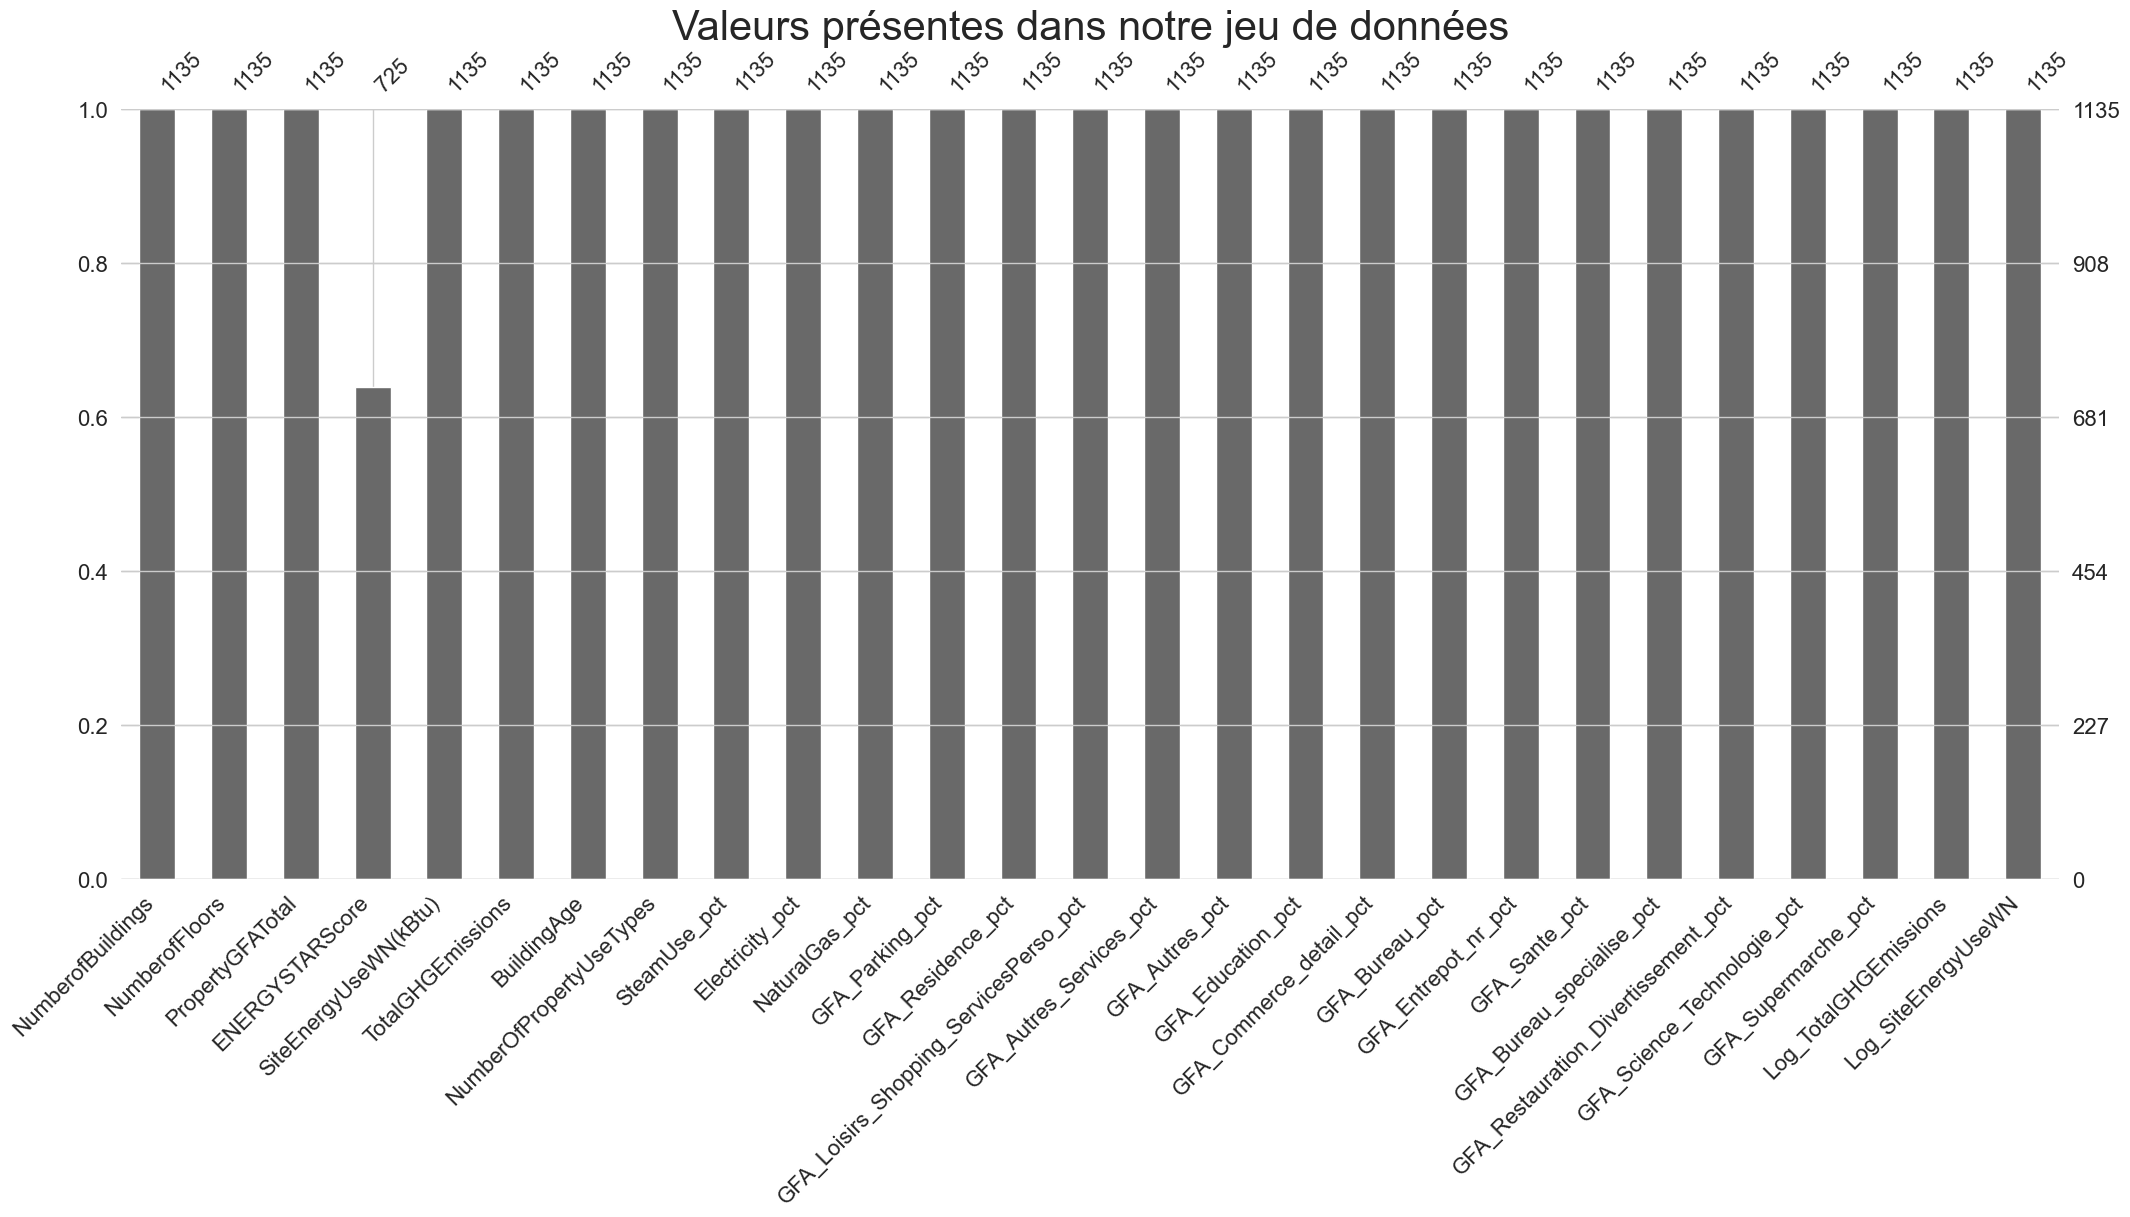

In [157]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(df_selected)